In [1]:
import numpy as np
import pandas as pd
import warnings
import time

warnings.filterwarnings('ignore')

print("=" * 80)
print("US ACCIDENTS SEVERITY PREDICTION PIPELINE")
print("=" * 80)

# =============================================================================
# PART 1: DATA RETRIEVAL FROM KAGGLE
# =============================================================================
print("\n[PART 1] RETRIEVING DATA FROM KAGGLE")
print("-" * 80)

import kagglehub
from kagglehub import KaggleDatasetAdapter

print("Downloading dataset from Kaggle...")
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "sobhanmoosavi/us-accidents",
    "US_Accidents_March23.csv"
)

print("Dataset loaded: {:,} rows x {} columns".format(df.shape[0], df.shape[1]))
print("Memory usage: {:.2f} MB".format(df.memory_usage(deep=True).sum() / 1024**2))

# =============================================================================
# PART 2: INITIAL DATA EXPLORATION
# =============================================================================
print("\n[PART 2] INITIAL DATA EXPLORATION")
print("-" * 80)

print("\nDataset Info:")
print("  Shape: {}".format(df.shape))
print("  Columns: {}".format(df.shape[1]))

print("\nSeverity Distribution (Original):")
severity_dist = df['Severity'].value_counts().sort_index()
total = len(df)
for sev, count in severity_dist.items():
    pct = count / total * 100
    print("  Severity {}: {:,} ({:.2f}%)".format(sev, count, pct))

# =============================================================================
# PART 3: FEATURE ENGINEERING
# =============================================================================
print("\n[PART 3] FEATURE ENGINEERING")
print("-" * 80)

print("\nCreating time-based features...")

df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')

df['year'] = df['Start_Time'].dt.year
df['month'] = df['Start_Time'].dt.month
df['day'] = df['Start_Time'].dt.day
df['hour'] = df['Start_Time'].dt.hour
df['dow'] = df['Start_Time'].dt.dayofweek

df['is_weekend'] = (df['dow'] >= 5).astype(int)
df['is_morning_peak'] = ((df['hour'] >= 6) & (df['hour'] <= 9)).astype(int)
df['is_evening_peak'] = ((df['hour'] >= 16) & (df['hour'] <= 19)).astype(int)

print("Time features created successfully")

print("\nCreating weather flags...")

def create_weather_flags(dataframe):
    """Create binary flags for different weather conditions"""
    if 'Weather_Condition' not in dataframe.columns:
        return dataframe
    
    weather = dataframe['Weather_Condition'].fillna('').str.lower()
    
    dataframe['is_rain'] = weather.str.contains('rain|drizzle|shower', regex=True).astype(int)
    dataframe['is_snow'] = weather.str.contains('snow|sleet|ice|wintry', regex=True).astype(int)
    dataframe['is_fog'] = weather.str.contains('fog|mist|haze', regex=True).astype(int)
    dataframe['is_thunder'] = weather.str.contains('thunder|t-storm|storm', regex=True).astype(int)
    dataframe['is_wind'] = weather.str.contains('wind', regex=True).astype(int)
    
    return dataframe

df = create_weather_flags(df)

if 'Sunrise_Sunset' in df.columns:
    df['is_night'] = (df['Sunrise_Sunset'] == 'Night').astype(int)
else:
    df['is_night'] = ((df['hour'] < 6) | (df['hour'] >= 20)).astype(int)

print("Weather flags created successfully")

# =============================================================================
# PART 4: FEATURE SELECTION & DATA CLEANING
# =============================================================================
print("\n[PART 4] FEATURE SELECTION & DATA CLEANING")
print("-" * 80)

numeric_features = [
    'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 
    'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 
    'Distance(mi)'
]

boolean_features = [
    'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 
    'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 
    'Traffic_Calming', 'Traffic_Signal'
]

time_features = [
    'hour', 'dow', 'month', 'year', 'day', 
    'is_weekend', 'is_morning_peak', 'is_evening_peak'
]

weather_flags = [
    'is_rain', 'is_snow', 'is_fog', 'is_thunder', 'is_wind', 'is_night'
]

all_features = []
for feature in numeric_features + boolean_features + time_features + weather_flags:
    if feature in df.columns:
        all_features.append(feature)
    else:
        print("  Warning: Feature '{}' not found in dataset".format(feature))

print("\nTotal features selected: {}".format(len(all_features)))

print("\nCreating ML dataset...")
ml_df = df[all_features + ['Severity']].copy()

print("Before dropping NaN: {:,} rows".format(len(ml_df)))
ml_df = ml_df.dropna()
print("After dropping NaN: {:,} rows".format(len(ml_df)))

# =============================================================================
# PART 5: HANDLE CLASS IMBALANCE WITH BALANCED SAMPLING
# =============================================================================
print("\n[PART 5] HANDLING CLASS IMBALANCE")
print("=" * 80)

print("\nOriginal Distribution (imbalanced):")
print("-" * 80)
for sev, count in ml_df['Severity'].value_counts().sort_index().items():
    pct = count / len(ml_df) * 100
    print("  Severity {}: {:>10,} ({:>5.2f}%)".format(sev, count, pct))

class_counts = ml_df['Severity'].value_counts().sort_index()
min_class_size = class_counts.min()
min_severity = class_counts.idxmin()

print("\nClass Distribution Analysis:")
print("  Smallest class: Severity {} with {:,} samples".format(min_severity, min_class_size))
print("  Largest class: Severity {} with {:,} samples".format(class_counts.idxmax(), class_counts.max()))
print("  Imbalance ratio: {:.0f}:1".format(class_counts.max() / min_class_size))

# =============================================================================
# SAMPLING STRATEGY
# Use minimum class size to preserve all minority class data
# =============================================================================
print("\n" + "=" * 80)
print("SAMPLING STRATEGY: Undersample majorities to match minority class")
print("=" * 80)

TARGET_PER_CLASS = int(min_class_size)

print("\nTarget: {:,} samples per class (matches minority class size)".format(TARGET_PER_CLASS))
print("Total after balancing: {:,} samples".format(TARGET_PER_CLASS * 4))
print("No minority class data will be discarded")

from sklearn.utils import resample

print("\nApplying balanced resampling...")
print("-" * 80)

balanced_dfs = []

for severity in sorted(ml_df['Severity'].unique()):
    severity_df = ml_df[ml_df['Severity'] == severity]
    current_size = len(severity_df)
    
    if current_size >= TARGET_PER_CLASS:
        print("Severity {}: Undersampling {:>10,} -> {:,}".format(severity, current_size, TARGET_PER_CLASS))
        sampled = resample(
            severity_df, 
            n_samples=TARGET_PER_CLASS, 
            random_state=42, 
            replace=False
        )
    else:
        oversample_factor = TARGET_PER_CLASS / current_size
        print("Severity {}: Oversampling  {:>10,} -> {:,} ({:.1f}x)".format(
            severity, current_size, TARGET_PER_CLASS, oversample_factor))
        sampled = resample(
            severity_df, 
            n_samples=TARGET_PER_CLASS, 
            random_state=42, 
            replace=True
        )
    
    balanced_dfs.append(sampled)

ml_df_balanced = pd.concat(balanced_dfs, ignore_index=True)
ml_df_balanced = ml_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("\n" + "=" * 80)
print("BALANCED Distribution (after sampling):")
print("=" * 80)
for sev, count in ml_df_balanced['Severity'].value_counts().sort_index().items():
    pct = count / len(ml_df_balanced) * 100
    print("  Severity {}: {:>10,} ({:>5.1f}%)".format(sev, count, pct))

print("\nSummary:")
print("  Total samples: {:,}".format(len(ml_df_balanced)))
print("  From original: {:,}".format(len(ml_df)))
print("  Utilization: {:.2f}%".format(len(ml_df_balanced)/len(ml_df)*100))
print("  All classes now at 25.0%")

# =============================================================================
# PART 6: PREPARE DATA FOR MULTI-CLASS CLASSIFICATION
# =============================================================================
print("\n[PART 6] PREPARING MULTI-CLASS CLASSIFICATION")
print("=" * 80)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

multiclass_X = ml_df_balanced.drop('Severity', axis=1)
multiclass_y = ml_df_balanced['Severity']

label_encoder = LabelEncoder()
multiclass_y_encoded = label_encoder.fit_transform(multiclass_y)

print("\nDataset prepared:")
print("  Features: {}".format(multiclass_X.shape[1]))
print("  Samples: {:,}".format(len(multiclass_y_encoded)))
print("  Classes: {}".format(label_encoder.classes_))

multiclass_X_train, multiclass_X_test, multiclass_y_train, multiclass_y_test = train_test_split(
    multiclass_X, multiclass_y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=multiclass_y_encoded
)

print("\nTrain-test split:")
print("  Training: {:,} samples ({:.0f}%)".format(
    len(multiclass_X_train), len(multiclass_X_train)/len(multiclass_X)*100))
print("  Testing:  {:,} samples ({:.0f}%)".format(
    len(multiclass_X_test), len(multiclass_X_test)/len(multiclass_X)*100))

multiclass_scaler = StandardScaler()
multiclass_X_train_scaled = multiclass_scaler.fit_transform(multiclass_X_train)
multiclass_X_test_scaled = multiclass_scaler.transform(multiclass_X_test)

multiclass_feature_names = multiclass_X.columns.tolist()

print("Data scaled and ready for training")

# =============================================================================
# PART 7: PREPARE DATA FOR BINARY CLASSIFICATION
# =============================================================================
print("\n[PART 7] PREPARING BINARY CLASSIFICATION")
print("=" * 80)

binary_y = ml_df_balanced['Severity'].map({1: 0, 2: 0, 3: 1, 4: 1})

print("\nBinary mapping:")
print("  Severity 1, 2 -> LOW  (0)")
print("  Severity 3, 4 -> HIGH (1)")

print("\nBinary distribution:")
for cls, count in binary_y.value_counts().sort_index().items():
    label = "LOW" if cls == 0 else "HIGH"
    pct = count / len(binary_y) * 100
    print("  {:4} ({}): {:,} ({:.1f}%)".format(label, cls, count, pct))

binary_X_train, binary_X_test, binary_y_train, binary_y_test = train_test_split(
    multiclass_X, binary_y, 
    test_size=0.2, 
    random_state=42, 
    stratify=binary_y
)

print("\nBinary split:")
print("  Training: {:,} samples".format(len(binary_X_train)))
print("  Testing:  {:,} samples".format(len(binary_X_test)))

binary_scaler = StandardScaler()
binary_X_train_scaled = binary_scaler.fit_transform(binary_X_train)
binary_X_test_scaled = binary_scaler.transform(binary_X_test)

binary_feature_names = binary_X_train.columns.tolist()

print("Binary data scaled and ready")

# =============================================================================
# PART 8: TRAIN MULTI-CLASS MODELS
# =============================================================================
print("\n[PART 8] TRAINING MULTI-CLASS MODELS")
print("=" * 80)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

multiclass_models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000, 
        random_state=42, 
        multi_class='multinomial',
        n_jobs=-1
    ),
    'Decision Tree': DecisionTreeClassifier(
        max_depth=20,
        min_samples_split=5,
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        max_depth=10,
        learning_rate=0.1,
        random_state=42
    ),
    'K-Nearest Neighbors': KNeighborsClassifier(
        n_neighbors=5,
        n_jobs=-1
    )
}

multiclass_results = {}
multiclass_predictions = {}
multiclass_probabilities = {}
multiclass_trained_models = {}

print("\nTraining {} models on {:,} samples...".format(len(multiclass_models), len(multiclass_X_train)))
print("-" * 80)

for name, model in multiclass_models.items():
    print("\n{}".format(name))
    print("  " + "-" * 40)
    
    start_time = time.time()
    
    needs_scaling = 'Logistic' in name or 'KNN' in name or 'K-Nearest' in name
    
    if needs_scaling:
        model.fit(multiclass_X_train_scaled, multiclass_y_train)
        y_pred = model.predict(multiclass_X_test_scaled)
        y_prob = model.predict_proba(multiclass_X_test_scaled)
    else:
        model.fit(multiclass_X_train, multiclass_y_train)
        y_pred = model.predict(multiclass_X_test)
        y_prob = model.predict_proba(multiclass_X_test)
    
    train_time = time.time() - start_time
    
    multiclass_trained_models[name] = model
    multiclass_predictions[name] = y_pred
    multiclass_probabilities[name] = y_prob
    
    multiclass_results[name] = {
        'Accuracy': accuracy_score(multiclass_y_test, y_pred),
        'Precision': precision_score(multiclass_y_test, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(multiclass_y_test, y_pred, average='weighted', zero_division=0),
        'F1-Score': f1_score(multiclass_y_test, y_pred, average='weighted', zero_division=0),
        'Training Time': train_time
    }
    
    print("  Accuracy:  {:.4f}".format(multiclass_results[name]['Accuracy']))
    print("  Precision: {:.4f}".format(multiclass_results[name]['Precision']))
    print("  Recall:    {:.4f}".format(multiclass_results[name]['Recall']))
    print("  F1-Score:  {:.4f}".format(multiclass_results[name]['F1-Score']))
    print("  Time:      {:.2f}s".format(train_time))

print("\n" + "=" * 80)
print("MULTI-CLASS TRAINING COMPLETE")
print("=" * 80)

# =============================================================================
# PART 9: TRAIN BINARY MODELS
# =============================================================================
print("\n[PART 9] TRAINING BINARY CLASSIFICATION MODELS")
print("=" * 80)

from sklearn.metrics import roc_auc_score

binary_models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        random_state=42,
        n_jobs=-1
    ),
    'Decision Tree': DecisionTreeClassifier(
        max_depth=20,
        min_samples_split=5,
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        max_depth=10,
        learning_rate=0.1,
        random_state=42
    ),
    'K-Nearest Neighbors': KNeighborsClassifier(
        n_neighbors=5,
        n_jobs=-1
    )
}

binary_results = {}
binary_predictions = {}
binary_probabilities = {}
binary_trained_models = {}

print("\nTraining {} models...".format(len(binary_models)))
print("-" * 80)

for name, model in binary_models.items():
    print("\n{}".format(name))
    print("  " + "-" * 40)
    
    start_time = time.time()
    
    needs_scaling = 'Logistic' in name or 'KNN' in name or 'K-Nearest' in name
    
    if needs_scaling:
        model.fit(binary_X_train_scaled, binary_y_train)
        y_pred = model.predict(binary_X_test_scaled)
        y_prob = model.predict_proba(binary_X_test_scaled)[:, 1]
    else:
        model.fit(binary_X_train, binary_y_train)
        y_pred = model.predict(binary_X_test)
        y_prob = model.predict_proba(binary_X_test)[:, 1]
    
    train_time = time.time() - start_time
    
    binary_trained_models[name] = model
    binary_predictions[name] = y_pred
    binary_probabilities[name] = y_prob
    
    binary_results[name] = {
        'Accuracy': accuracy_score(binary_y_test, y_pred),
        'Precision': precision_score(binary_y_test, y_pred, zero_division=0),
        'Recall': recall_score(binary_y_test, y_pred, zero_division=0),
        'F1-Score': f1_score(binary_y_test, y_pred, zero_division=0),
        'AUC-ROC': roc_auc_score(binary_y_test, y_prob),
        'Training Time': train_time
    }
    
    print("  Accuracy:  {:.4f}".format(binary_results[name]['Accuracy']))
    print("  Precision: {:.4f}".format(binary_results[name]['Precision']))
    print("  Recall:    {:.4f}".format(binary_results[name]['Recall']))
    print("  F1-Score:  {:.4f}".format(binary_results[name]['F1-Score']))
    print("  AUC-ROC:   {:.4f}".format(binary_results[name]['AUC-ROC']))
    print("  Time:      {:.2f}s".format(train_time))

print("\n" + "=" * 80)
print("BINARY CLASSIFICATION TRAINING COMPLETE")
print("=" * 80)

# =============================================================================
# PART 10: SUMMARY AND MODEL RANKINGS
# =============================================================================
print("\n[PART 10] FINAL SUMMARY")
print("=" * 80)

print("\nMULTI-CLASS MODEL RANKINGS (by Accuracy):")
print("-" * 80)
sorted_multiclass = sorted(multiclass_results.items(), key=lambda x: x[1]['Accuracy'], reverse=True)
for rank, (model, metrics) in enumerate(sorted_multiclass, 1):
    print("{}. {:25} -> Acc: {:.4f} | F1: {:.4f} | Time: {:.1f}s".format(
        rank, model, metrics['Accuracy'], metrics['F1-Score'], metrics['Training Time']))

print("\nBINARY MODEL RANKINGS (by AUC-ROC):")
print("-" * 80)
sorted_binary = sorted(binary_results.items(), key=lambda x: x[1]['AUC-ROC'], reverse=True)
for rank, (model, metrics) in enumerate(sorted_binary, 1):
    print("{}. {:25} -> AUC: {:.4f} | F1: {:.4f} | Time: {:.1f}s".format(
        rank, model, metrics['AUC-ROC'], metrics['F1-Score'], metrics['Training Time']))

print("\n" + "=" * 80)
print("PIPELINE COMPLETE")
print("=" * 80)

print("\nDataset Summary:")
print("  Balanced samples per class: {:,}".format(TARGET_PER_CLASS))
print("  Total training samples: {:,}".format(TARGET_PER_CLASS * 4))
print("  All minority class data preserved")
print("  Class balance achieved: 25% per severity level")

print("\n" + "=" * 80)


US ACCIDENTS SEVERITY PREDICTION PIPELINE

[PART 1] RETRIEVING DATA FROM KAGGLE
--------------------------------------------------------------------------------
Dataset loaded: 7,728,394 rows x 46 columns
Memory usage: 10870.28 MB

[PART 2] INITIAL DATA EXPLORATION
--------------------------------------------------------------------------------

Dataset Info:
  Shape: (7728394, 46)
  Columns: 46

Severity Distribution (Original):
  Severity 1: 67,366 (0.87%)
  Severity 2: 6,156,981 (79.67%)
  Severity 3: 1,299,337 (16.81%)
  Severity 4: 204,710 (2.65%)

[PART 3] FEATURE ENGINEERING
--------------------------------------------------------------------------------

Creating time-based features...
Time features created successfully

Creating weather flags...
Weather flags created successfully

[PART 4] FEATURE SELECTION & DATA CLEANING
--------------------------------------------------------------------------------

Total features selected: 33

Creating ML dataset...
Before dropping NaN: 7

Output directory: /Users/akash/dev/DATA230/accident_severity_prediction/output-plot

[VISUALIZATIONS] Generating Multi-Class Plots...


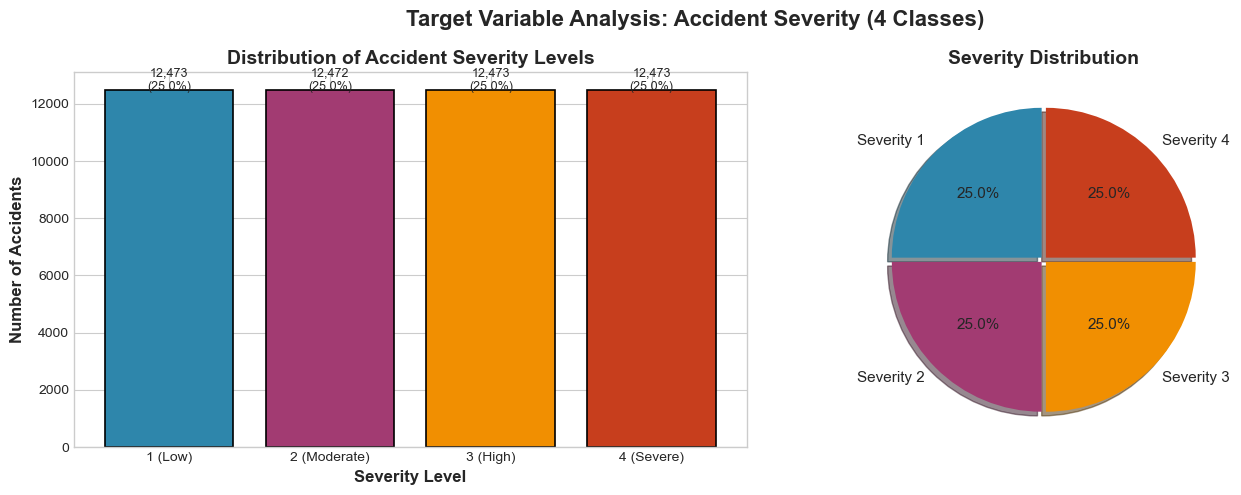

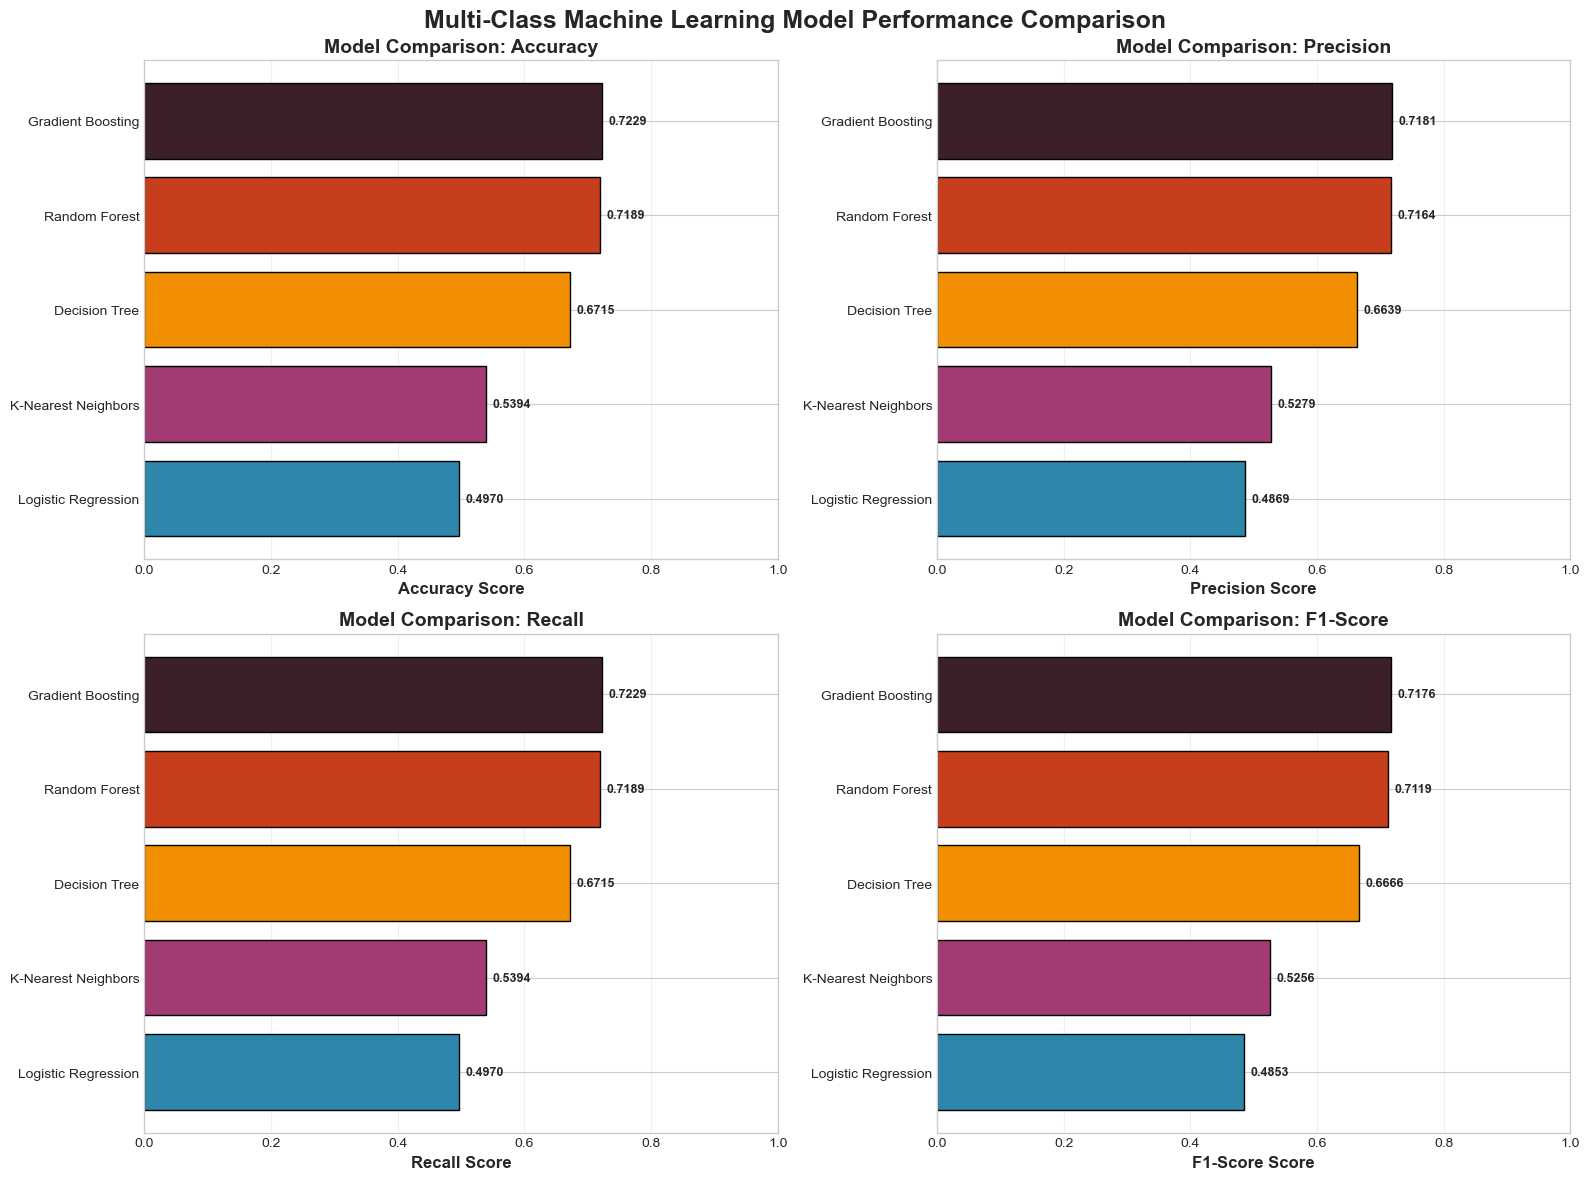

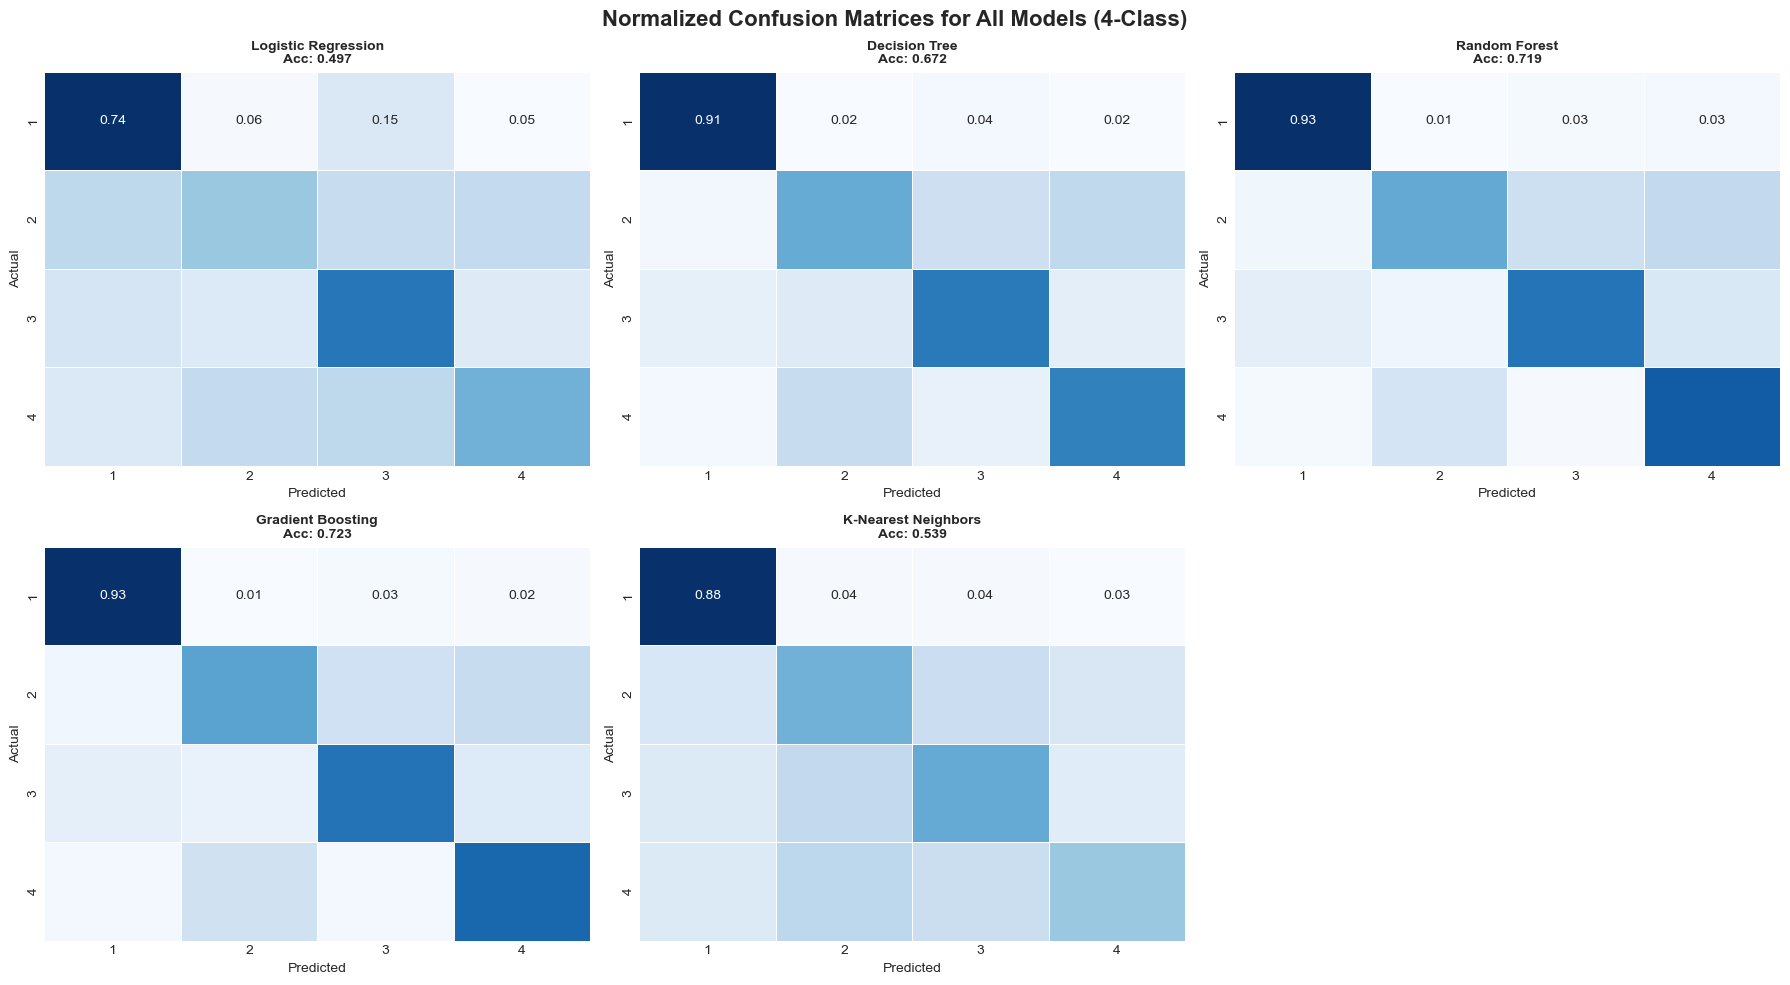

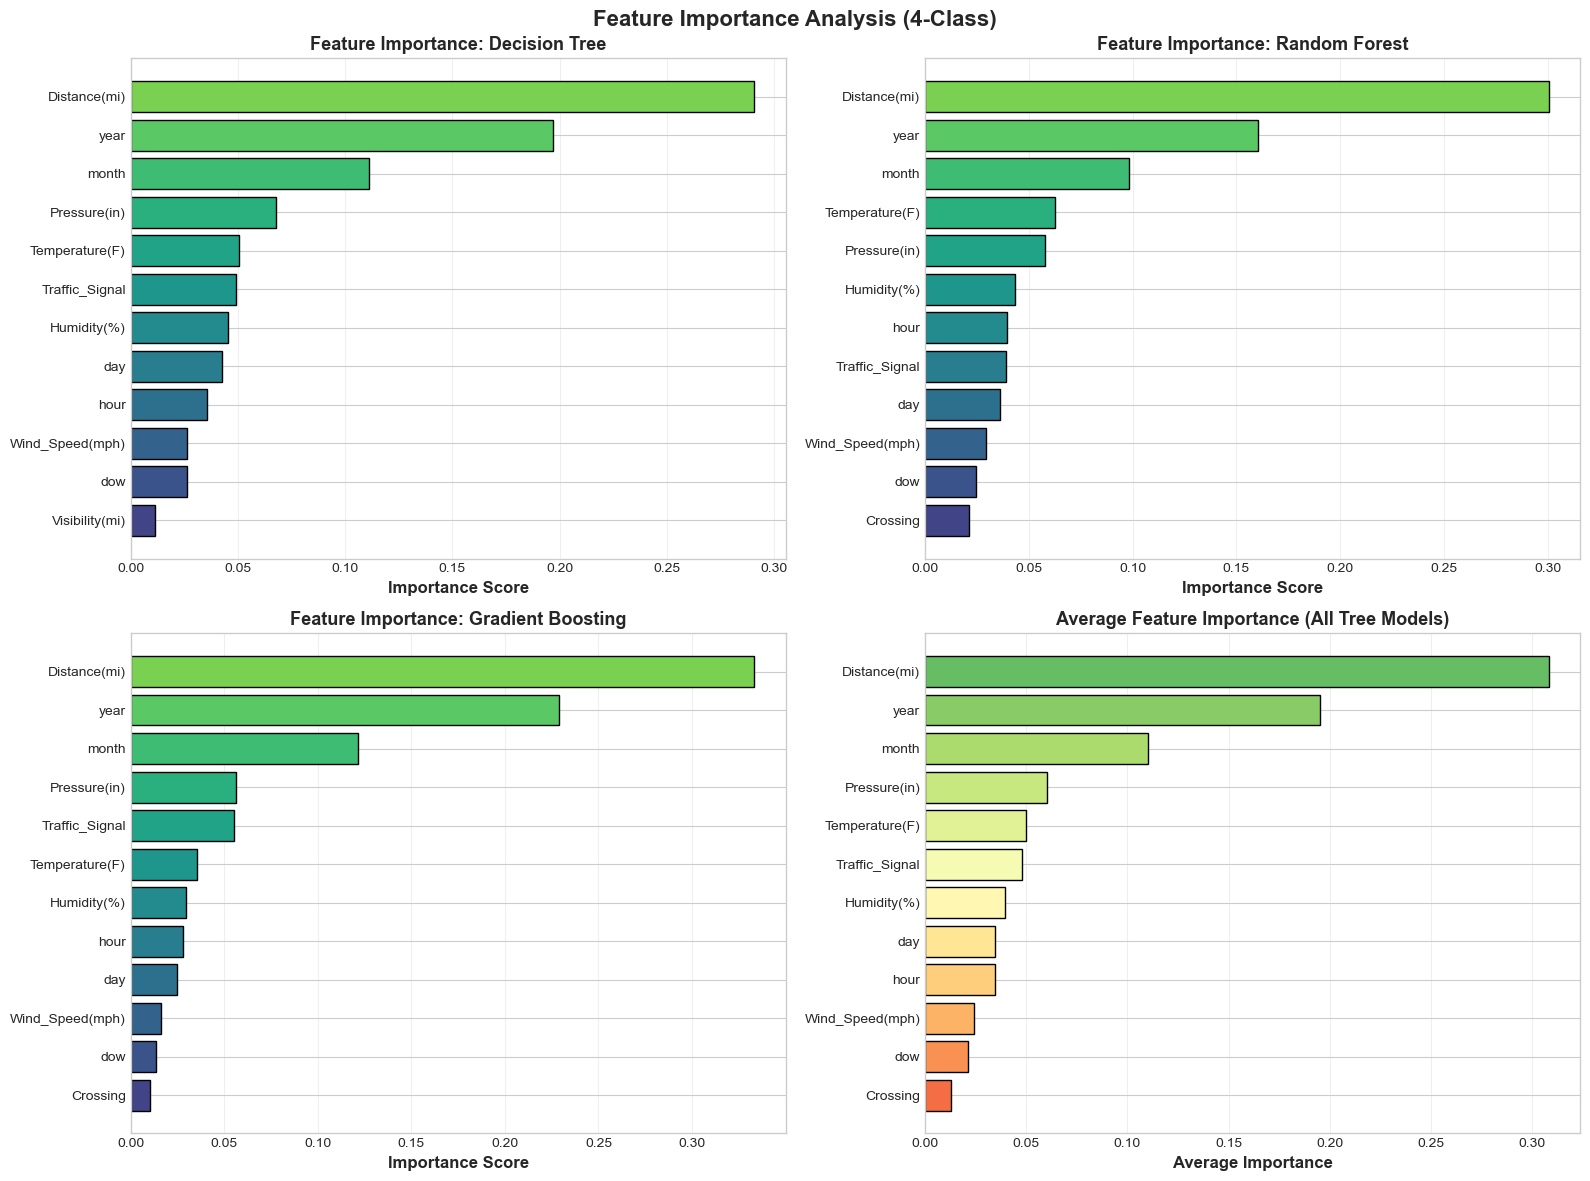

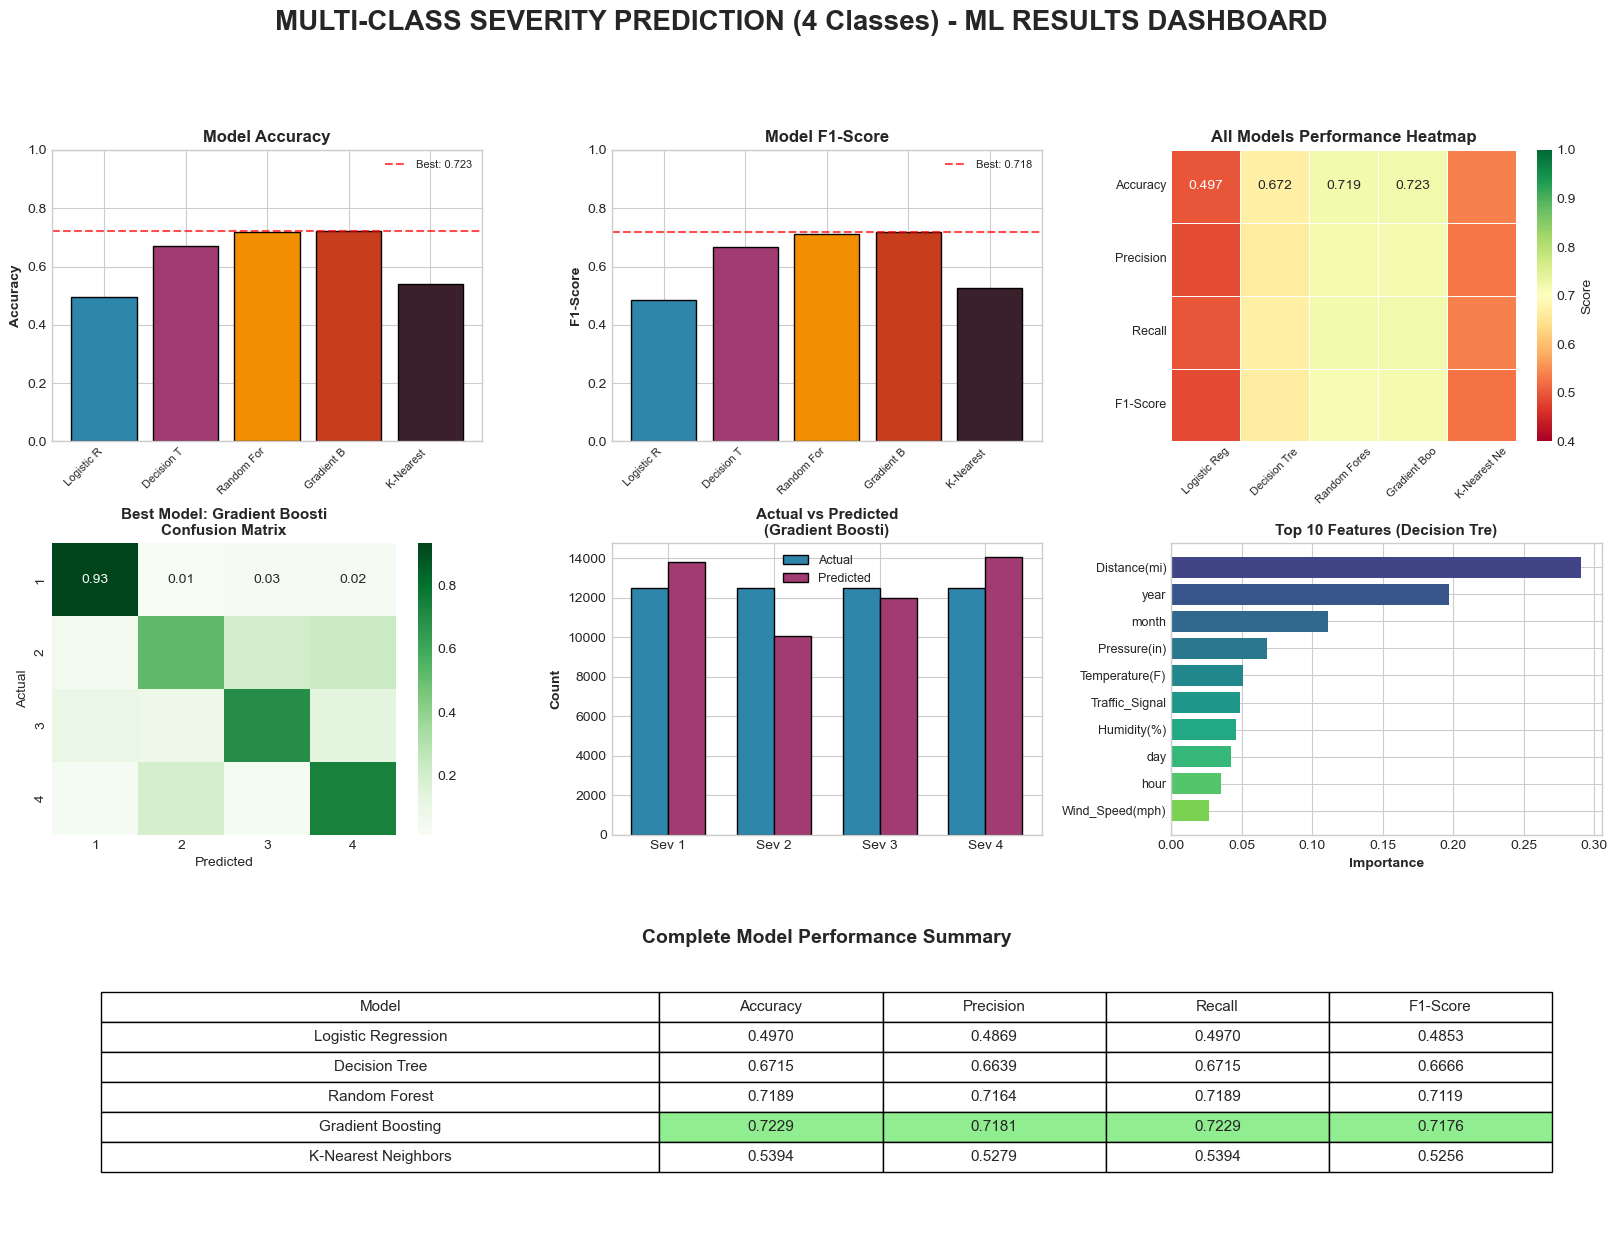


Multi-Class Visualizations Complete!


In [2]:
# =============================================================================
# MULTI-CLASS VISUALIZATIONS 
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_curve, auc
import os

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
COLORS = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#3B1F2B', '#95C623', '#5D5D5D']

# Create output directory if it doesn't exist
OUTPUT_DIR = '/Users/akash/dev/DATA230/accident_severity_prediction/output-plot'
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Output directory: {OUTPUT_DIR}")

# Get class info
multiclass_original_classes = label_encoder.classes_
multiclass_n_classes = len(multiclass_original_classes)

# =============================================================================
# VISUALIZATION 1: CLASS DISTRIBUTION
# =============================================================================
print("\n[VISUALIZATIONS] Generating Multi-Class Plots...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

severity_counts = pd.Series(multiclass_y_test).value_counts().sort_index()
colors_sev = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'][:multiclass_n_classes]

# Bar plot
bars = axes[0].bar(range(len(severity_counts)), severity_counts.values, color=colors_sev, 
                   edgecolor='black', linewidth=1.2)
axes[0].set_xlabel('Severity Level', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Accidents', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Accident Severity Levels', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(len(multiclass_original_classes)))
severity_names = ['Low', 'Moderate', 'High', 'Severe'][:multiclass_n_classes]
axes[0].set_xticklabels([f'{c} ({severity_names[i]})' for i, c in enumerate(multiclass_original_classes)])

for bar, count in zip(bars, severity_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
                f'{count:,}\n({count/len(multiclass_y_test)*100:.1f}%)', ha='center', fontsize=9)

# Pie chart
axes[1].pie(severity_counts.values, 
            labels=[f'Severity {c}' for c in multiclass_original_classes],
            colors=colors_sev, autopct='%1.1f%%', startangle=90, 
            explode=[0.02]*len(severity_counts), shadow=True, textprops={'fontsize': 11})
axes[1].set_title('Severity Distribution', fontsize=14, fontweight='bold')

plt.suptitle('Target Variable Analysis: Accident Severity (4 Classes)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/viz1_class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# =============================================================================
# VISUALIZATION 2: MODEL PERFORMANCE COMPARISON
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

multiclass_results_df = pd.DataFrame(multiclass_results).T
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    sorted_results = multiclass_results_df[metric].sort_values(ascending=True)
    
    bars = ax.barh(range(len(sorted_results)), sorted_results.values, 
                   color=COLORS[:len(sorted_results)], edgecolor='black', linewidth=1)
    
    ax.set_yticks(range(len(sorted_results)))
    ax.set_yticklabels(sorted_results.index, fontsize=10)
    ax.set_xlabel(f'{metric} Score', fontsize=12, fontweight='bold')
    ax.set_title(f'Model Comparison: {metric}', fontsize=14, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.grid(True, axis='x', alpha=0.3)
    
    for bar, val in zip(bars, sorted_results.values):
        ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, 
               f'{val:.4f}', va='center', fontsize=9, fontweight='bold')

plt.suptitle('Multi-Class Machine Learning Model Performance Comparison', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/viz2_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# =============================================================================
# VISUALIZATION 3: CONFUSION MATRICES
# =============================================================================
n_models = len(multiclass_predictions)
n_cols = min(3, n_models)
n_rows = (n_models + n_cols - 1) // n_cols  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
if n_models == 1:
    axes = np.array([axes])
axes = axes.flatten()

class_labels = [str(c) for c in multiclass_original_classes]

for idx, (name, y_pred) in enumerate(multiclass_predictions.items()):
    ax = axes[idx]
    
    cm = confusion_matrix(multiclass_y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax,
                xticklabels=class_labels, yticklabels=class_labels,
                cbar=False, linewidths=0.5, linecolor='white')
    ax.set_xlabel('Predicted', fontsize=10)
    ax.set_ylabel('Actual', fontsize=10)
    ax.set_title(f'{name}\nAcc: {multiclass_results[name]["Accuracy"]:.3f}', fontsize=10, fontweight='bold')

# Hide empty subplots
for idx in range(n_models, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Normalized Confusion Matrices for All Models (4-Class)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/viz3_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

# # =============================================================================
# # VISUALIZATION 4: ROC CURVES
# # =============================================================================
# fig, ax = plt.subplots(figsize=(12, 10))

# classes = list(range(multiclass_n_classes))
# multiclass_y_test_bin = label_binarize(multiclass_y_test, classes=classes)

# for idx, (name, y_prob) in enumerate(multiclass_probabilities.items()):
#     fpr = dict()
#     tpr = dict()
    
#     for i in range(multiclass_n_classes):
#         fpr[i], tpr[i], _ = roc_curve(multiclass_y_test_bin[:, i], y_prob[:, i])
    
#     all_fpr = np.unique(np.concatenate([fpr[i] for i in range(multiclass_n_classes)]))
#     mean_tpr = np.zeros_like(all_fpr)
#     for i in range(multiclass_n_classes):
#         mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
#     mean_tpr /= multiclass_n_classes
    
#     macro_auc = auc(all_fpr, mean_tpr)
#     ax.plot(all_fpr, mean_tpr, color=COLORS[idx % len(COLORS)], lw=2.5, 
#            label=f'{name} (AUC = {macro_auc:.3f})')

# ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
# ax.set_xlim([0.0, 1.0])
# ax.set_ylim([0.0, 1.05])
# ax.set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
# ax.set_ylabel('True Positive Rate', fontsize=14, fontweight='bold')
# ax.set_title('ROC Curves (Macro-Average) - All Models Comparison', fontsize=16, fontweight='bold')
# ax.legend(loc='lower right', fontsize=10, framealpha=0.9)
# ax.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.savefig(f'{OUTPUT_DIR}/viz4_roc_curves.png', dpi=150, bbox_inches='tight')
# plt.show()
#
# =============================================================================
# VISUALIZATION 5: FEATURE IMPORTANCE
# =============================================================================
# Get tree-based models for feature importance
multiclass_importance_models = {}
for name, model in multiclass_trained_models.items():
    if hasattr(model, 'feature_importances_'):
        multiclass_importance_models[name] = model

if multiclass_importance_models:
    n_importance_models = len(multiclass_importance_models)
    # Create grid: models + 1 for average
    n_plots = min(n_importance_models + 1, 4)
    n_cols = 2
    n_rows = (n_plots + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 6*n_rows))
    axes = axes.flatten()
    
    plot_models = list(multiclass_importance_models.items())[:3]
    
    for idx, (name, model) in enumerate(plot_models):
        ax = axes[idx]
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:12]
        
        colors_imp = plt.cm.viridis(np.linspace(0.2, 0.8, len(indices)))[::-1]
        
        ax.barh(range(len(indices)), importances[indices], color=colors_imp, edgecolor='black')
        ax.set_yticks(range(len(indices)))
        ax.set_yticklabels([multiclass_feature_names[i] for i in indices], fontsize=10)
        ax.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
        ax.set_title(f'Feature Importance: {name}', fontsize=13, fontweight='bold')
        ax.invert_yaxis()
        ax.grid(True, axis='x', alpha=0.3)
    
    # Average importance
    ax = axes[min(len(plot_models), 3)]
    avg_importance = np.zeros(len(multiclass_feature_names))
    for name, model in multiclass_importance_models.items():
        avg_importance += model.feature_importances_
    avg_importance /= len(multiclass_importance_models)
    
    indices = np.argsort(avg_importance)[::-1][:12]
    colors_imp = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(indices)))[::-1]
    
    ax.barh(range(len(indices)), avg_importance[indices], color=colors_imp, edgecolor='black')
    ax.set_yticks(range(len(indices)))
    ax.set_yticklabels([multiclass_feature_names[i] for i in indices], fontsize=10)
    ax.set_xlabel('Average Importance', fontsize=12, fontweight='bold')
    ax.set_title('Average Feature Importance (All Tree Models)', fontsize=13, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(True, axis='x', alpha=0.3)
    
    # Hide unused subplots
    for idx in range(n_plots, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Feature Importance Analysis (4-Class)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/viz5_feature_importance.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No tree-based models available for feature importance visualization")

# =============================================================================
# VISUALIZATION 6: COMPREHENSIVE SUMMARY DASHBOARD
# =============================================================================
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# Helper function to get short model names
def get_short_name(name, max_len=12):
    """Get shortened model name without causing errors"""
    return name[:max_len] if len(name) > max_len else name

model_names = list(multiclass_results.keys())
model_short = [get_short_name(m, 10) for m in model_names]

# 1. Accuracy Comparison
ax1 = fig.add_subplot(gs[0, 0])
accuracies = [multiclass_results[m]['Accuracy'] for m in model_names]
bars = ax1.bar(range(len(model_names)), accuracies, color=COLORS[:len(model_names)], edgecolor='black')
ax1.set_xticks(range(len(model_names)))
ax1.set_xticklabels(model_short, rotation=45, ha='right', fontsize=8)
ax1.set_ylabel('Accuracy', fontsize=10, fontweight='bold')
ax1.set_title('Model Accuracy', fontsize=12, fontweight='bold')
ax1.set_ylim(0, 1)
ax1.axhline(y=max(accuracies), color='red', linestyle='--', alpha=0.7, label=f'Best: {max(accuracies):.3f}')
ax1.legend(fontsize=8)

# 2. F1-Score Comparison
ax2 = fig.add_subplot(gs[0, 1])
f1_scores = [multiclass_results[m]['F1-Score'] for m in model_names]
bars = ax2.bar(range(len(model_names)), f1_scores, color=COLORS[:len(model_names)], edgecolor='black')
ax2.set_xticks(range(len(model_names)))
ax2.set_xticklabels(model_short, rotation=45, ha='right', fontsize=8)
ax2.set_ylabel('F1-Score', fontsize=10, fontweight='bold')
ax2.set_title('Model F1-Score', fontsize=12, fontweight='bold')
ax2.set_ylim(0, 1)
ax2.axhline(y=max(f1_scores), color='red', linestyle='--', alpha=0.7, label=f'Best: {max(f1_scores):.3f}')
ax2.legend(fontsize=8)

# 3. All Models Heatmap
ax3 = fig.add_subplot(gs[0, 2])
heatmap_data = multiclass_results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']]
model_labels = [get_short_name(m, 12) for m in heatmap_data.index]
sns.heatmap(heatmap_data.T, annot=True, fmt='.3f', cmap='RdYlGn', ax=ax3,
            xticklabels=model_labels, yticklabels=heatmap_data.columns,
            cbar_kws={'label': 'Score'}, vmin=0.4, vmax=1.0, linewidths=0.5)
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.set_title('All Models Performance Heatmap', fontsize=12, fontweight='bold')
ax3.tick_params(axis='x', rotation=45, labelsize=8)
ax3.tick_params(axis='y', rotation=0, labelsize=9)

# 4. Best Model Confusion Matrix
ax4 = fig.add_subplot(gs[1, 0])
best_model = max(multiclass_results.keys(), key=lambda x: multiclass_results[x]['Accuracy'])
cm = confusion_matrix(multiclass_y_test, multiclass_predictions[best_model])
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens', ax=ax4,
            xticklabels=class_labels, yticklabels=class_labels)
ax4.set_xlabel('Predicted', fontsize=10)
ax4.set_ylabel('Actual', fontsize=10)
ax4.set_title(f'Best Model: {get_short_name(best_model, 15)}\nConfusion Matrix', fontsize=11, fontweight='bold')

# 5. Actual vs Predicted Distribution
ax5 = fig.add_subplot(gs[1, 1])
x_pos = np.arange(multiclass_n_classes)
width = 0.35
actual_counts = np.bincount(multiclass_y_test, minlength=multiclass_n_classes)
pred_counts = np.bincount(multiclass_predictions[best_model], minlength=multiclass_n_classes)
ax5.bar(x_pos - width/2, actual_counts, width, label='Actual', color=COLORS[0], edgecolor='black')
ax5.bar(x_pos + width/2, pred_counts, width, label='Predicted', color=COLORS[1], edgecolor='black')
ax5.set_xticks(x_pos)
ax5.set_xticklabels([f'Sev {c}' for c in multiclass_original_classes])
ax5.set_ylabel('Count', fontsize=10, fontweight='bold')
ax5.set_title(f'Actual vs Predicted\n({get_short_name(best_model, 15)})', fontsize=11, fontweight='bold')
ax5.legend(fontsize=9)

# 6. Top Features
ax6 = fig.add_subplot(gs[1, 2])
if multiclass_importance_models:
    best_tree_model_name = list(multiclass_importance_models.keys())[0]
    best_tree_model = multiclass_importance_models[best_tree_model_name]
    importances = best_tree_model.feature_importances_
    indices = np.argsort(importances)[::-1][:10]
    ax6.barh(range(10), importances[indices], color=plt.cm.viridis(np.linspace(0.2, 0.8, 10)))
    ax6.set_yticks(range(10))
    ax6.set_yticklabels([multiclass_feature_names[i] for i in indices], fontsize=9)
    ax6.invert_yaxis()
    ax6.set_xlabel('Importance', fontsize=10, fontweight='bold')
    ax6.set_title(f'Top 10 Features ({get_short_name(best_tree_model_name, 12)})', fontsize=11, fontweight='bold')
else:
    ax6.text(0.5, 0.5, 'No tree-based models\navailable', ha='center', va='center', fontsize=12)
    ax6.axis('off')

# 7. Results Table
ax7 = fig.add_subplot(gs[2, :])
ax7.axis('off')

table_data = []
for model in model_names:
    row = [model, 
           f"{multiclass_results[model]['Accuracy']:.4f}",
           f"{multiclass_results[model]['Precision']:.4f}",
           f"{multiclass_results[model]['Recall']:.4f}",
           f"{multiclass_results[model]['F1-Score']:.4f}"]
    table_data.append(row)

table = ax7.table(cellText=table_data,
                  colLabels=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'],
                  cellLoc='center', loc='center',
                  colWidths=[0.3, 0.12, 0.12, 0.12, 0.12])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8)

# Highlight best values in green
for i, model in enumerate(model_names):
    for j, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1-Score']):
        max_val = max([multiclass_results[m][metric] for m in model_names])
        if multiclass_results[model][metric] == max_val:
            table[(i+1, j+1)].set_facecolor('#90EE90')

ax7.set_title('Complete Model Performance Summary', fontsize=14, fontweight='bold', y=0.95)

plt.suptitle('MULTI-CLASS SEVERITY PREDICTION (4 Classes) - ML RESULTS DASHBOARD', 
             fontsize=20, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/viz6_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nMulti-Class Visualizations Complete!")

Output directory: /Users/akash/dev/DATA230/accident_severity_prediction/output-plot

[VISUALIZATIONS] Generating Binary Classification Plots...


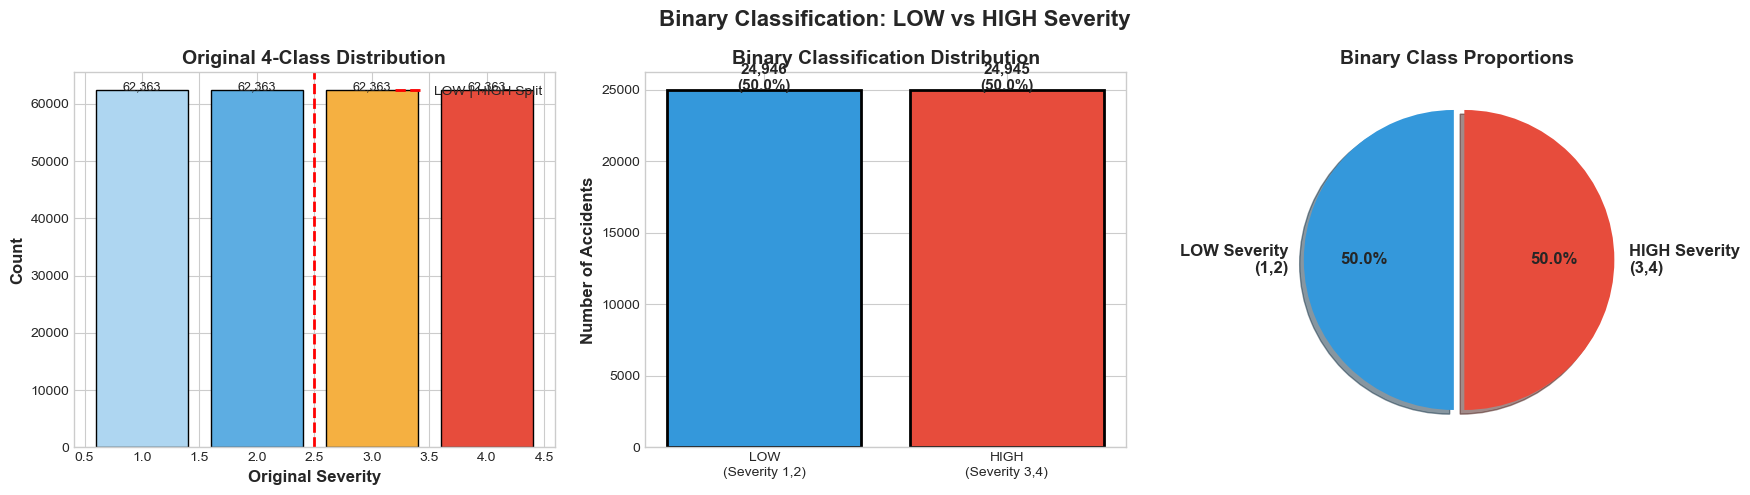

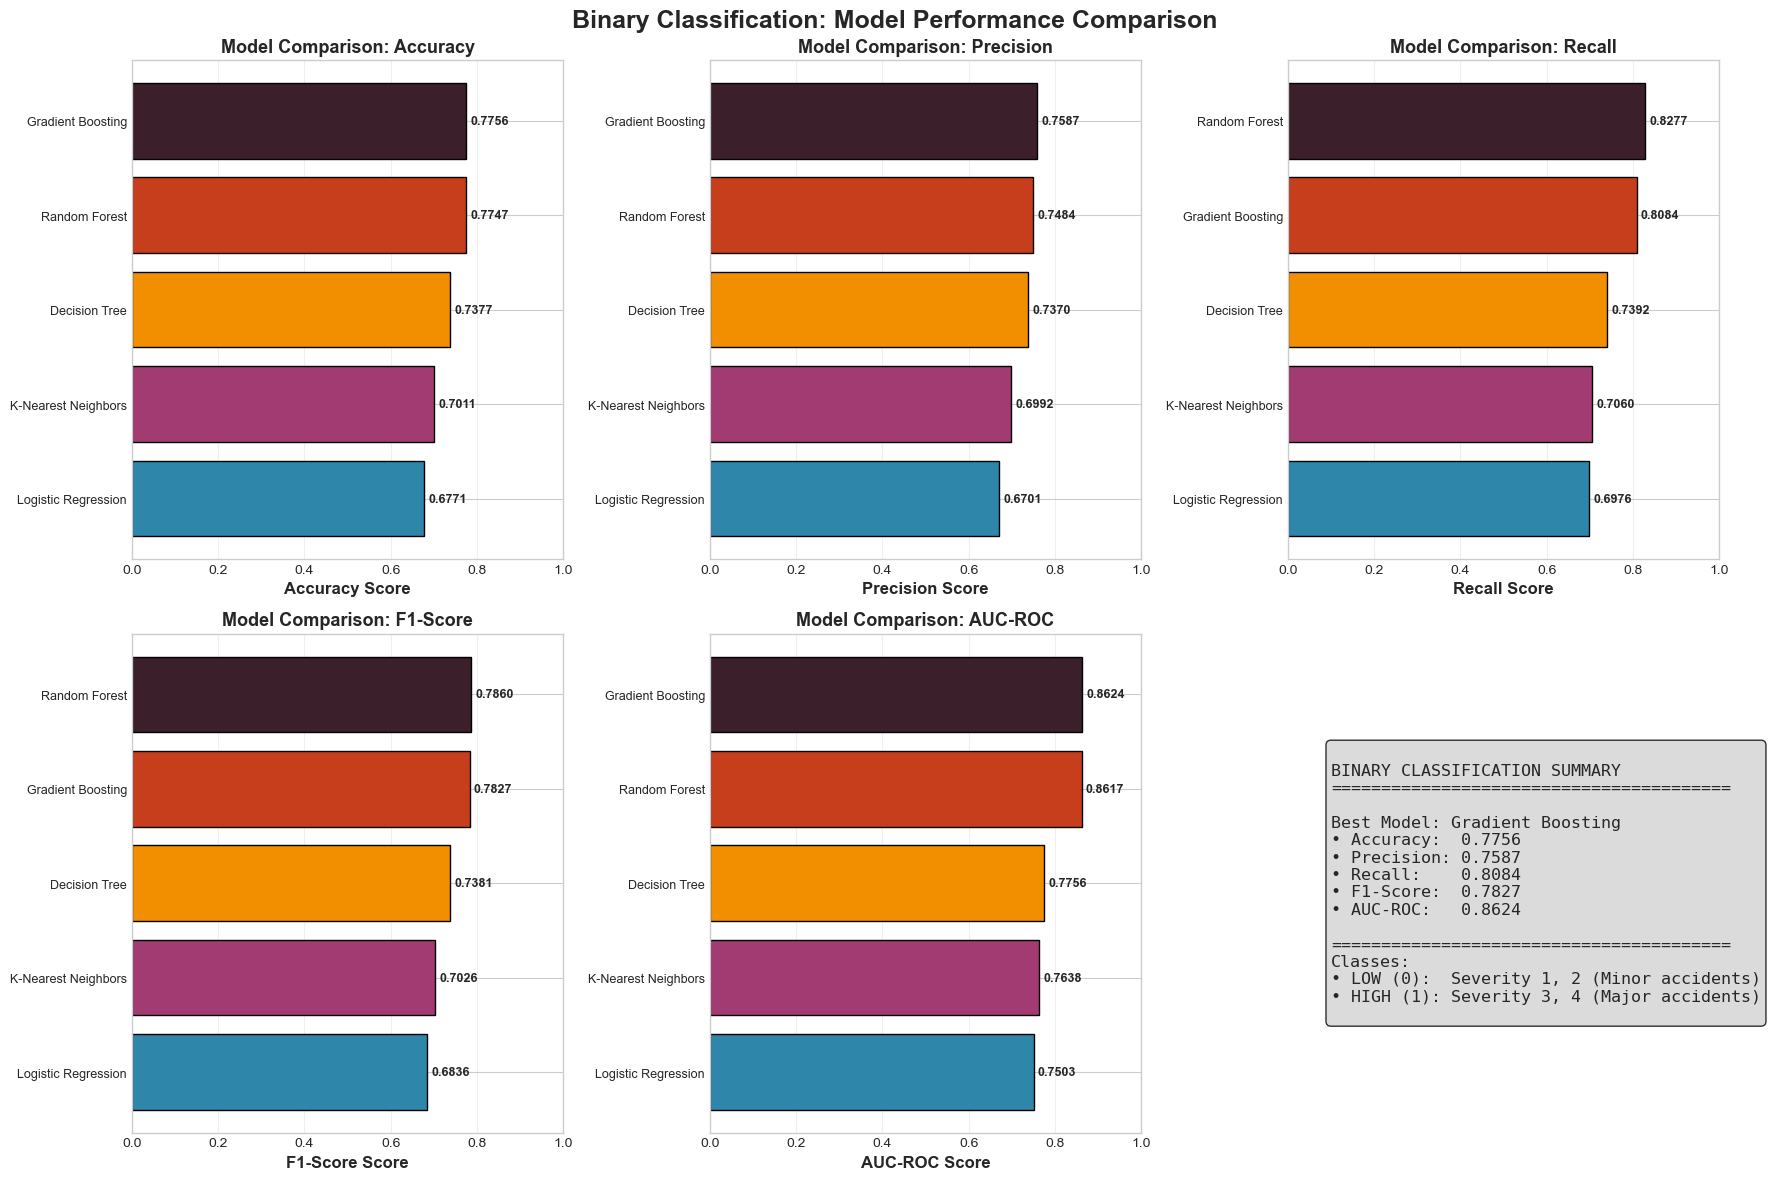

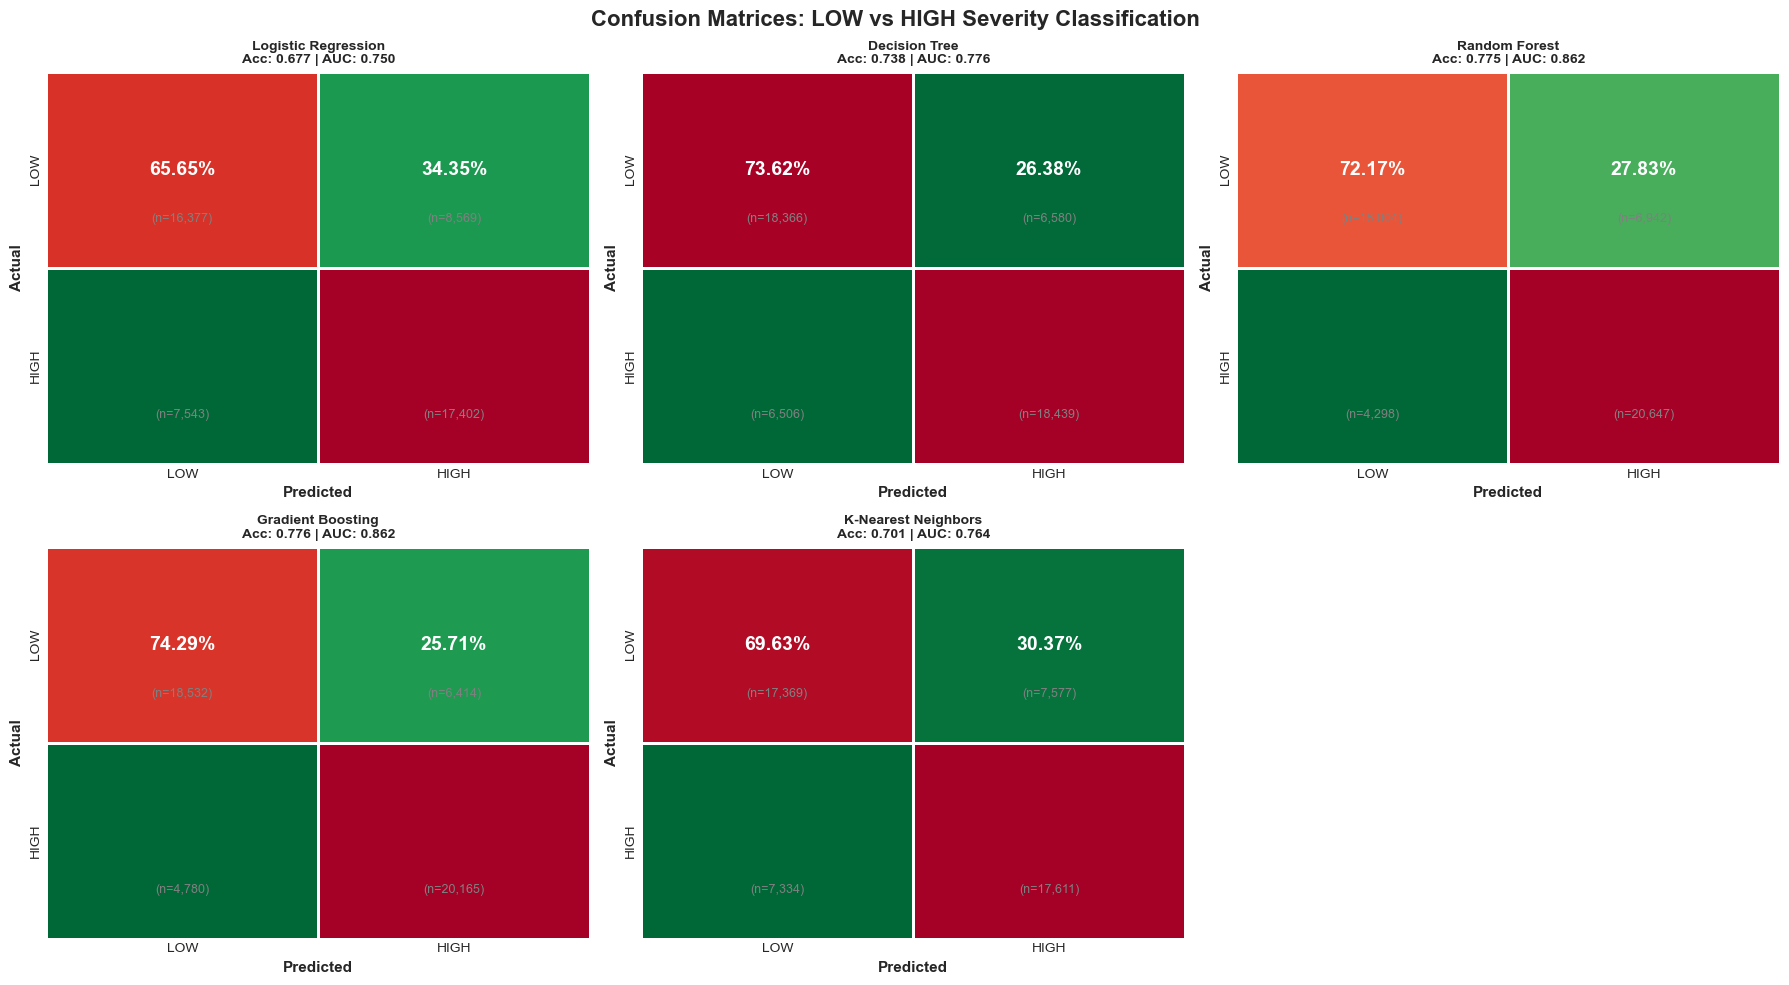

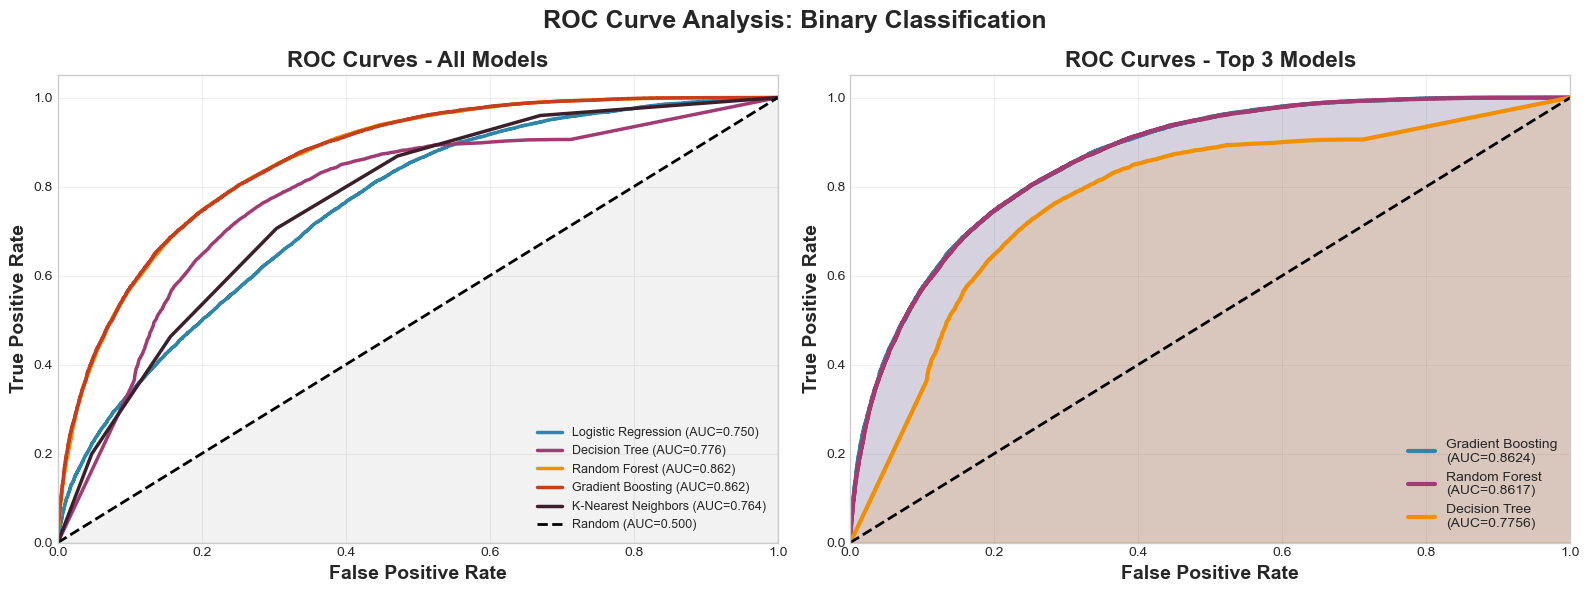

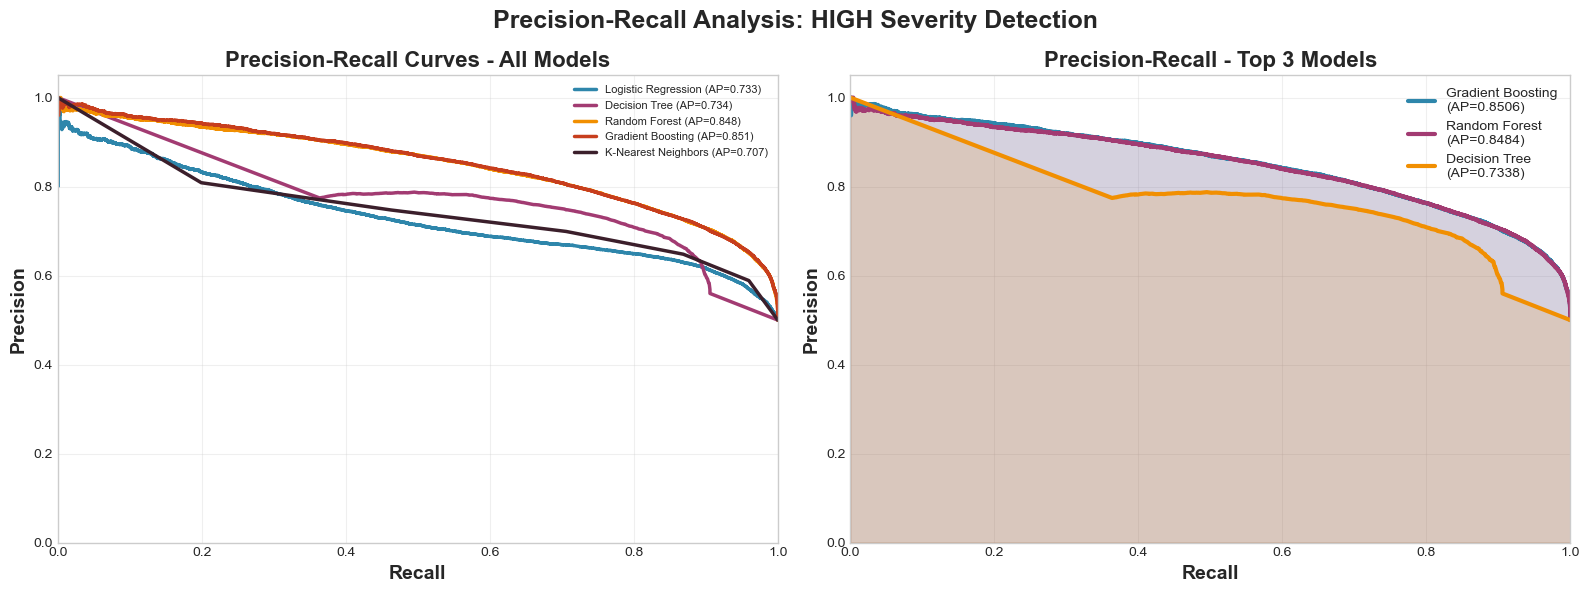

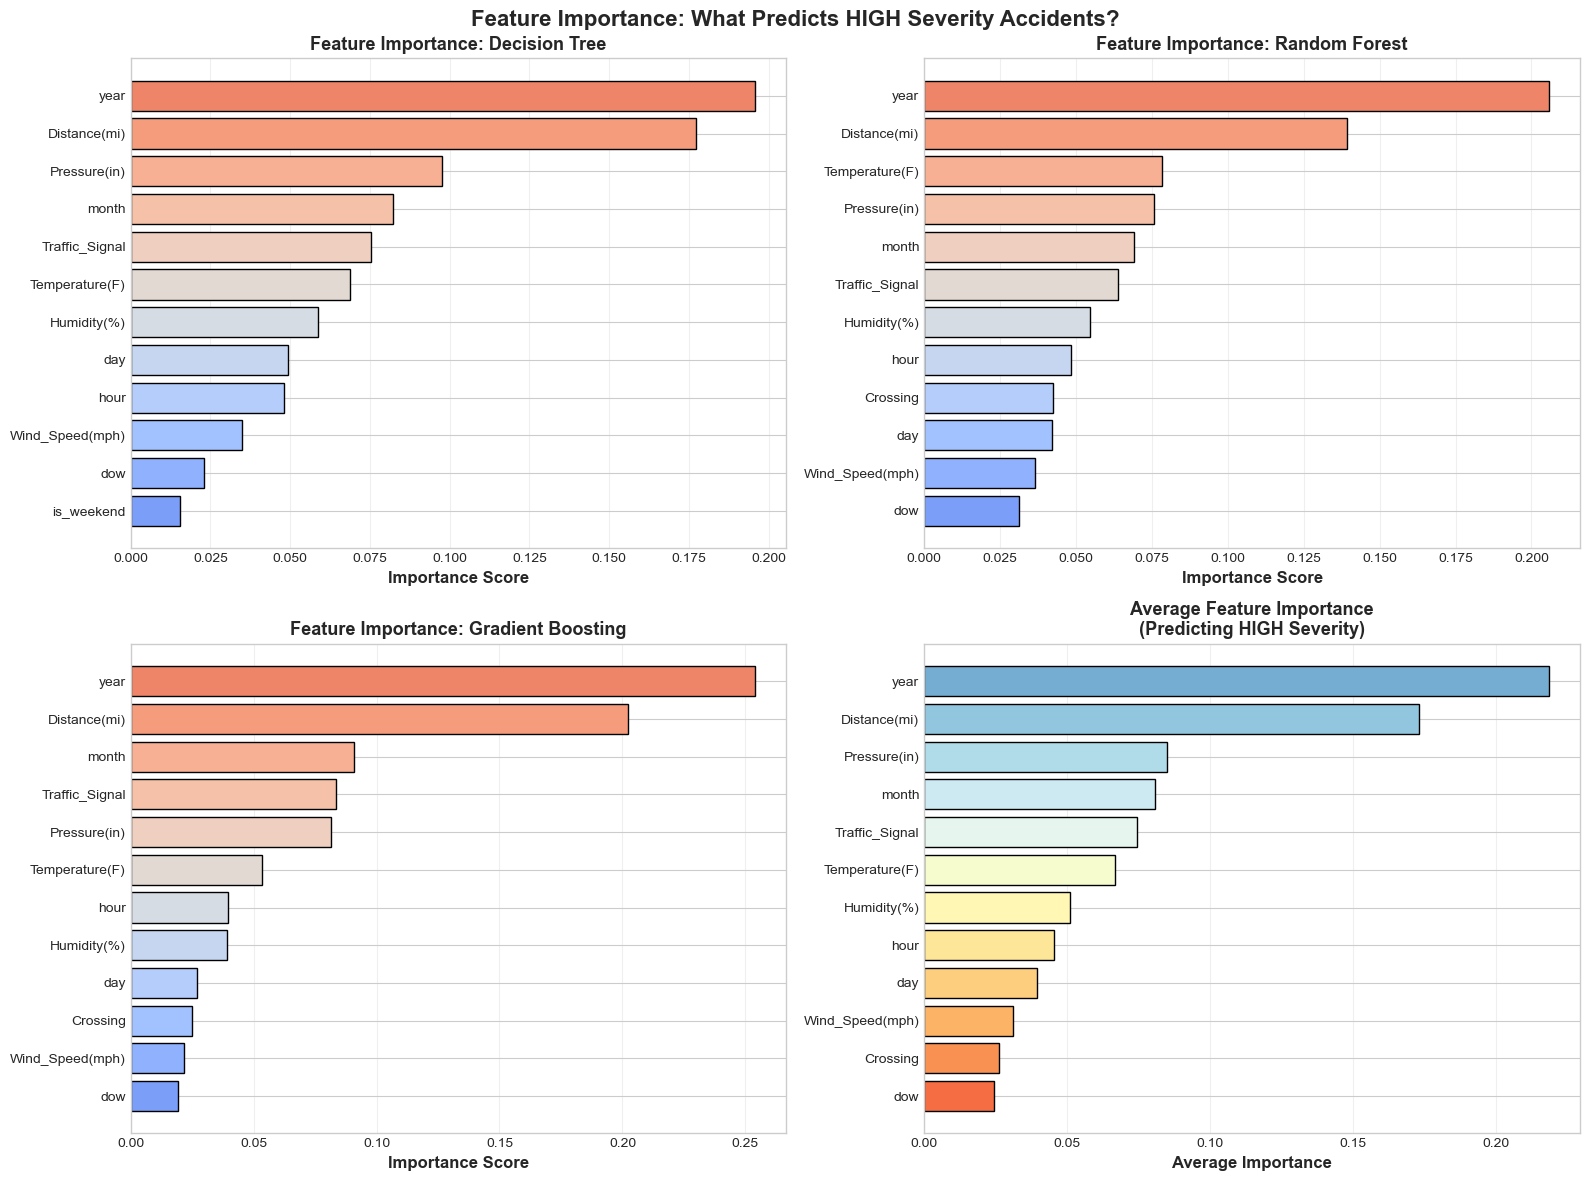

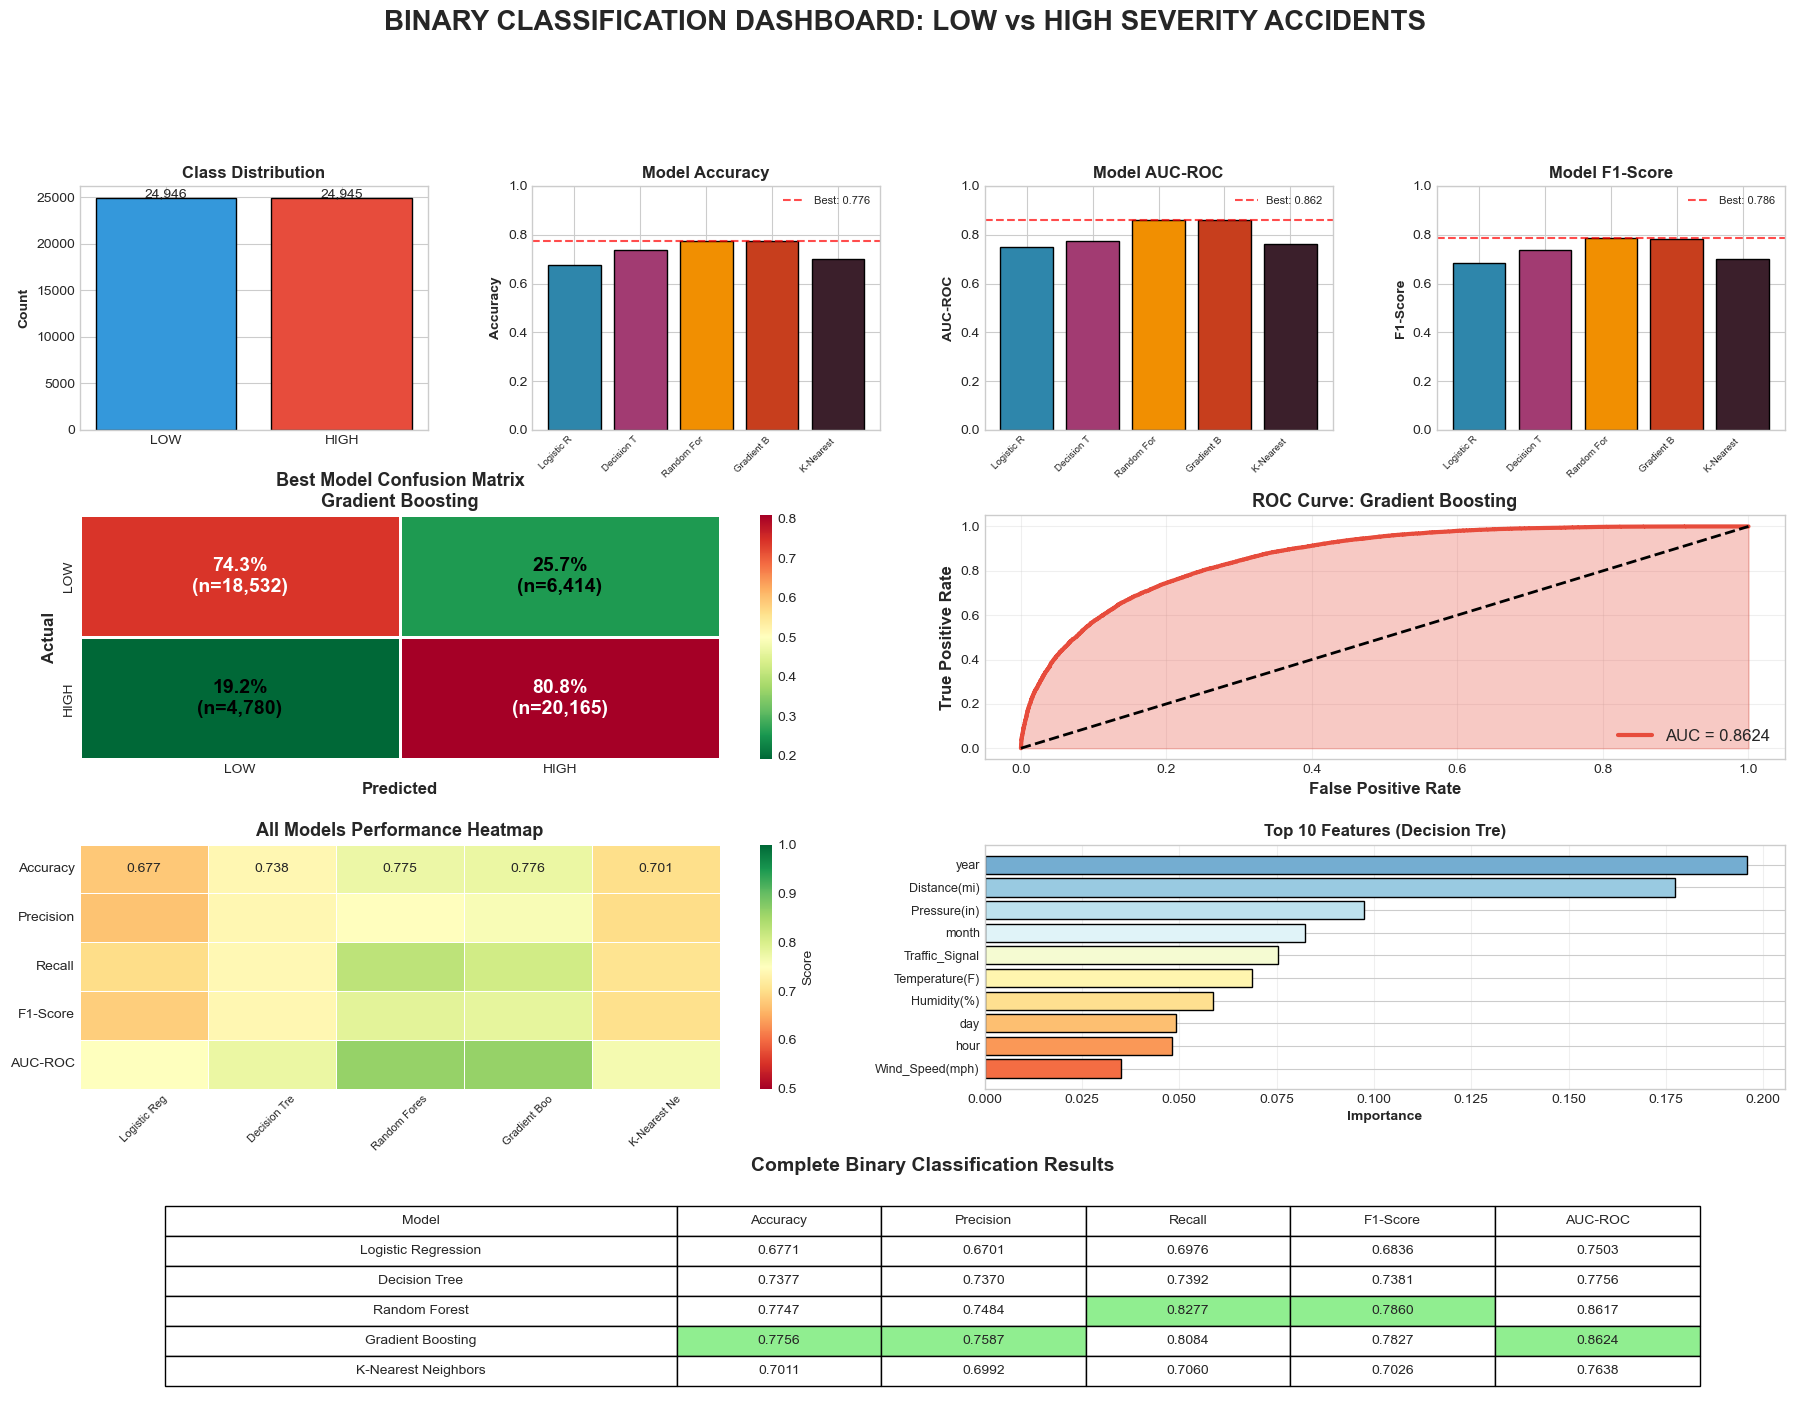


Binary Classification Visualizations Complete!


In [3]:
# =============================================================================
# BINARY CLASSIFICATION VISUALIZATIONS
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import os
import numpy as np

# Set style (matching multi-class)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
COLORS = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#3B1F2B', '#95C623', '#5D5D5D', '#E84855']

# Create output directory if it doesn't exist
OUTPUT_DIR = '/Users/akash/dev/DATA230/accident_severity_prediction/output-plot'
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Output directory: {OUTPUT_DIR}")

# Helper function (matching multi-class)
def get_short_name(name, max_len=12):
    """Get shortened model name without causing errors"""
    return name[:max_len] if len(name) > max_len else name

print("\n[VISUALIZATIONS] Generating Binary Classification Plots...")

# =============================================================================
# VISUALIZATION 1: BINARY CLASS DISTRIBUTION
# =============================================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original severity mapping
ax = axes[0]
original_counts = ml_df_balanced['Severity'].value_counts().sort_index()
colors_orig = ['#AED6F1', '#5DADE2', '#F5B041', '#E74C3C']
bars = ax.bar(original_counts.index, original_counts.values, color=colors_orig, edgecolor='black')
ax.set_xlabel('Original Severity', fontsize=12, fontweight='bold')
ax.set_ylabel('Count', fontsize=12, fontweight='bold')
ax.set_title('Original 4-Class Distribution', fontsize=14, fontweight='bold')
ax.axvline(x=2.5, color='red', linestyle='--', linewidth=2, label='LOW | HIGH Split')
ax.legend()
for bar, count in zip(bars, original_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
            f'{count:,}', ha='center', fontsize=9)

# Binary distribution - Bar
ax = axes[1]
binary_counts = pd.Series(binary_y_test).value_counts().sort_index()
colors_bin = ['#3498DB', '#E74C3C']
bars = ax.bar(['LOW\n(Severity 1,2)', 'HIGH\n(Severity 3,4)'], binary_counts.values, 
              color=colors_bin, edgecolor='black', linewidth=2)
ax.set_ylabel('Number of Accidents', fontsize=12, fontweight='bold')
ax.set_title('Binary Classification Distribution', fontsize=14, fontweight='bold')
for bar, count in zip(bars, binary_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
            f'{count:,}\n({count/len(binary_y_test)*100:.1f}%)', ha='center', fontsize=11, fontweight='bold')

# Binary distribution - Pie
ax = axes[2]
ax.pie(binary_counts.values, labels=['LOW Severity\n(1,2)', 'HIGH Severity\n(3,4)'],
       colors=colors_bin, autopct='%1.1f%%', startangle=90, explode=(0.02, 0.05),
       shadow=True, textprops={'fontsize': 12, 'fontweight': 'bold'})
ax.set_title('Binary Class Proportions', fontsize=14, fontweight='bold')

plt.suptitle('Binary Classification: LOW vs HIGH Severity', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/binary_viz1_class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# =============================================================================
# VISUALIZATION 2: MODEL PERFORMANCE COMPARISON (5 Metrics)
# =============================================================================
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

binary_results_df = pd.DataFrame(binary_results).T
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    sorted_results = binary_results_df[metric].sort_values(ascending=True)
    
    bars = ax.barh(range(len(sorted_results)), sorted_results.values, 
                   color=COLORS[:len(sorted_results)], edgecolor='black', linewidth=1)
    
    ax.set_yticks(range(len(sorted_results)))
    ax.set_yticklabels(sorted_results.index, fontsize=9)
    ax.set_xlabel(f'{metric} Score', fontsize=12, fontweight='bold')
    ax.set_title(f'Model Comparison: {metric}', fontsize=13, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.grid(True, axis='x', alpha=0.3)
    
    for bar, val in zip(bars, sorted_results.values):
        ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, 
               f'{val:.4f}', va='center', fontsize=9, fontweight='bold')

# Summary text in last subplot
ax = axes[5]
ax.axis('off')
binary_best_model = max(binary_results.keys(), key=lambda x: binary_results[x]['AUC-ROC'])
summary_text = f"""
BINARY CLASSIFICATION SUMMARY
{'='*40}

Best Model: {binary_best_model}
• Accuracy:  {binary_results[binary_best_model]['Accuracy']:.4f}
• Precision: {binary_results[binary_best_model]['Precision']:.4f}
• Recall:    {binary_results[binary_best_model]['Recall']:.4f}
• F1-Score:  {binary_results[binary_best_model]['F1-Score']:.4f}
• AUC-ROC:   {binary_results[binary_best_model]['AUC-ROC']:.4f}

{'='*40}
Classes:
• LOW (0):  Severity 1, 2 (Minor accidents)
• HIGH (1): Severity 3, 4 (Major accidents)
"""
ax.text(0.1, 0.5, summary_text, fontsize=12, fontfamily='monospace',
        verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.suptitle('Binary Classification: Model Performance Comparison', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/binary_viz2_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# =============================================================================
# VISUALIZATION 3: CONFUSION MATRICES (All Models) - FIXED GRID
# =============================================================================
n_models = len(binary_predictions)
n_cols = min(3, n_models)
n_rows = (n_models + n_cols - 1) // n_cols  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
if n_models == 1:
    axes = np.array([axes])
axes = axes.flatten()

class_labels = ['LOW', 'HIGH']

for idx, (name, y_pred) in enumerate(binary_predictions.items()):
    ax = axes[idx]
    
    cm = confusion_matrix(binary_y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn_r', ax=ax,
                xticklabels=class_labels, yticklabels=class_labels,
                cbar=False, linewidths=2, linecolor='white',
                annot_kws={'size': 14, 'weight': 'bold'})
    
    # Add raw counts
    for i in range(2):
        for j in range(2):
            ax.text(j + 0.5, i + 0.75, f'(n={cm[i,j]:,})', ha='center', va='center', 
                   fontsize=9, color='gray')
    
    ax.set_xlabel('Predicted', fontsize=11, fontweight='bold')
    ax.set_ylabel('Actual', fontsize=11, fontweight='bold')
    ax.set_title(f'{name}\nAcc: {binary_results[name]["Accuracy"]:.3f} | AUC: {binary_results[name]["AUC-ROC"]:.3f}', 
                fontsize=10, fontweight='bold')

# Hide empty subplots
for idx in range(n_models, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Confusion Matrices: LOW vs HIGH Severity Classification', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/binary_viz3_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

# =============================================================================
# VISUALIZATION 4: ROC CURVES (All Models)
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# All models ROC
ax = axes[0]
for idx, (name, y_prob) in enumerate(binary_probabilities.items()):
    fpr, tpr, _ = roc_curve(binary_y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=COLORS[idx % len(COLORS)], lw=2.5, label=f'{name} (AUC={roc_auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random (AUC=0.500)')
ax.fill_between([0, 1], [0, 1], alpha=0.1, color='gray')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=14, fontweight='bold')
ax.set_title('ROC Curves - All Models', fontsize=16, fontweight='bold')
ax.legend(loc='lower right', fontsize=9)
ax.grid(True, alpha=0.3)

# Best 3 models detailed
ax = axes[1]
binary_top_3 = sorted(binary_results.items(), key=lambda x: x[1]['AUC-ROC'], reverse=True)[:3]
for idx, (name, _) in enumerate(binary_top_3):
    y_prob = binary_probabilities[name]
    fpr, tpr, thresholds = roc_curve(binary_y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=COLORS[idx], lw=3, label=f'{name}\n(AUC={roc_auc:.4f})')
    ax.fill_between(fpr, tpr, alpha=0.15, color=COLORS[idx])

ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=14, fontweight='bold')
ax.set_title('ROC Curves - Top 3 Models', fontsize=16, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.suptitle('ROC Curve Analysis: Binary Classification', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/binary_viz4_roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# =============================================================================
# VISUALIZATION 5: PRECISION-RECALL CURVES
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# All models PR curve
ax = axes[0]
for idx, (name, y_prob) in enumerate(binary_probabilities.items()):
    precision, recall, _ = precision_recall_curve(binary_y_test, y_prob)
    ap = average_precision_score(binary_y_test, y_prob)
    ax.plot(recall, precision, color=COLORS[idx % len(COLORS)], lw=2.5, label=f'{name} (AP={ap:.3f})')

ax.set_xlabel('Recall', fontsize=14, fontweight='bold')
ax.set_ylabel('Precision', fontsize=14, fontweight='bold')
ax.set_title('Precision-Recall Curves - All Models', fontsize=16, fontweight='bold')
ax.legend(loc='best', fontsize=8)
ax.grid(True, alpha=0.3)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

# Top 3 models
ax = axes[1]
for idx, (name, _) in enumerate(binary_top_3):
    y_prob = binary_probabilities[name]
    precision, recall, _ = precision_recall_curve(binary_y_test, y_prob)
    ap = average_precision_score(binary_y_test, y_prob)
    ax.plot(recall, precision, color=COLORS[idx], lw=3, label=f'{name}\n(AP={ap:.4f})')
    ax.fill_between(recall, precision, alpha=0.15, color=COLORS[idx])

ax.set_xlabel('Recall', fontsize=14, fontweight='bold')
ax.set_ylabel('Precision', fontsize=14, fontweight='bold')
ax.set_title('Precision-Recall - Top 3 Models', fontsize=16, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

plt.suptitle('Precision-Recall Analysis: HIGH Severity Detection', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/binary_viz5_precision_recall.png', dpi=150, bbox_inches='tight')
plt.show()

# =============================================================================
# VISUALIZATION 6: FEATURE IMPORTANCE - FIXED (uses binary_trained_models)
# =============================================================================
# Get tree-based models for feature importance (FIXED: use trained_models dict)
binary_importance_models = {}
for name, model in binary_trained_models.items():
    if hasattr(model, 'feature_importances_'):
        binary_importance_models[name] = model

if binary_importance_models:
    n_importance_models = len(binary_importance_models)
    n_plots = min(n_importance_models + 1, 4)
    n_cols = 2
    n_rows = (n_plots + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 6*n_rows))
    axes = axes.flatten()
    
    plot_models = list(binary_importance_models.items())[:3]
    
    for idx, (name, model) in enumerate(plot_models):
        ax = axes[idx]
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:12]
        
        colors_imp = plt.cm.coolwarm(np.linspace(0.2, 0.8, len(indices)))[::-1]
        
        ax.barh(range(len(indices)), importances[indices], color=colors_imp, edgecolor='black')
        ax.set_yticks(range(len(indices)))
        ax.set_yticklabels([binary_feature_names[i] for i in indices], fontsize=10)
        ax.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
        ax.set_title(f'Feature Importance: {name}', fontsize=13, fontweight='bold')
        ax.invert_yaxis()
        ax.grid(True, axis='x', alpha=0.3)
    
    # Average importance
    ax = axes[min(len(plot_models), 3)]
    avg_importance = np.zeros(len(binary_feature_names))
    for name, model in binary_importance_models.items():
        avg_importance += model.feature_importances_
    avg_importance /= len(binary_importance_models)
    
    indices = np.argsort(avg_importance)[::-1][:12]
    colors_imp = plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, len(indices)))
    
    ax.barh(range(len(indices)), avg_importance[indices], color=colors_imp, edgecolor='black')
    ax.set_yticks(range(len(indices)))
    ax.set_yticklabels([binary_feature_names[i] for i in indices], fontsize=10)
    ax.set_xlabel('Average Importance', fontsize=12, fontweight='bold')
    ax.set_title('Average Feature Importance\n(Predicting HIGH Severity)', fontsize=13, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(True, axis='x', alpha=0.3)
    
    # Hide unused subplots
    for idx in range(n_plots, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Feature Importance: What Predicts HIGH Severity Accidents?', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/binary_viz6_feature_importance.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No tree-based models available for feature importance visualization")

# =============================================================================
# VISUALIZATION 7: COMPREHENSIVE BINARY CLASSIFICATION DASHBOARD - FIXED
# =============================================================================
fig = plt.figure(figsize=(22, 16))
gs = fig.add_gridspec(4, 4, hspace=0.35, wspace=0.3)

model_names = list(binary_results.keys())
model_short = [get_short_name(m, 10) for m in model_names]

# 1. Binary class distribution
ax1 = fig.add_subplot(gs[0, 0])
binary_counts = pd.Series(binary_y_test).value_counts().sort_index()
bars = ax1.bar(['LOW', 'HIGH'], binary_counts.values, color=['#3498DB', '#E74C3C'], edgecolor='black')
ax1.set_ylabel('Count', fontsize=10, fontweight='bold')
ax1.set_title('Class Distribution', fontsize=12, fontweight='bold')
for bar, count in zip(bars, binary_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
            f'{count:,}', ha='center', fontsize=10)

# 2. Accuracy comparison
ax2 = fig.add_subplot(gs[0, 1])
accuracies = [binary_results[m]['Accuracy'] for m in model_names]
bars = ax2.bar(range(len(model_names)), accuracies, color=COLORS[:len(model_names)], edgecolor='black')
ax2.set_xticks(range(len(model_names)))
ax2.set_xticklabels(model_short, rotation=45, ha='right', fontsize=7)
ax2.set_ylabel('Accuracy', fontsize=10, fontweight='bold')
ax2.set_title('Model Accuracy', fontsize=12, fontweight='bold')
ax2.set_ylim(0, 1)
ax2.axhline(y=max(accuracies), color='red', linestyle='--', alpha=0.7, label=f'Best: {max(accuracies):.3f}')
ax2.legend(fontsize=8)

# 3. AUC-ROC comparison
ax3 = fig.add_subplot(gs[0, 2])
aucs = [binary_results[m]['AUC-ROC'] for m in model_names]
bars = ax3.bar(range(len(model_names)), aucs, color=COLORS[:len(model_names)], edgecolor='black')
ax3.set_xticks(range(len(model_names)))
ax3.set_xticklabels(model_short, rotation=45, ha='right', fontsize=7)
ax3.set_ylabel('AUC-ROC', fontsize=10, fontweight='bold')
ax3.set_title('Model AUC-ROC', fontsize=12, fontweight='bold')
ax3.set_ylim(0, 1)
ax3.axhline(y=max(aucs), color='red', linestyle='--', alpha=0.7, label=f'Best: {max(aucs):.3f}')
ax3.legend(fontsize=8)

# 4. F1-Score comparison
ax4 = fig.add_subplot(gs[0, 3])
f1s = [binary_results[m]['F1-Score'] for m in model_names]
bars = ax4.bar(range(len(model_names)), f1s, color=COLORS[:len(model_names)], edgecolor='black')
ax4.set_xticks(range(len(model_names)))
ax4.set_xticklabels(model_short, rotation=45, ha='right', fontsize=7)
ax4.set_ylabel('F1-Score', fontsize=10, fontweight='bold')
ax4.set_title('Model F1-Score', fontsize=12, fontweight='bold')
ax4.set_ylim(0, 1)
ax4.axhline(y=max(f1s), color='red', linestyle='--', alpha=0.7, label=f'Best: {max(f1s):.3f}')
ax4.legend(fontsize=8)

# 5. Best model confusion matrix
ax5 = fig.add_subplot(gs[1, 0:2])
cm = confusion_matrix(binary_y_test, binary_predictions[binary_best_model])
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_norm, annot=False, cmap='RdYlGn_r', ax=ax5,
            xticklabels=['LOW', 'HIGH'], yticklabels=['LOW', 'HIGH'],
            linewidths=2, linecolor='white')

for i in range(2):
    for j in range(2):
        text = f'{cm_norm[i,j]:.1%}\n(n={cm[i,j]:,})'
        color = 'white' if cm_norm[i,j] > 0.5 else 'black'
        ax5.text(j + 0.5, i + 0.5, text, ha='center', va='center', 
                fontsize=14, fontweight='bold', color=color)

ax5.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax5.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax5.set_title(f'Best Model Confusion Matrix\n{binary_best_model}', fontsize=13, fontweight='bold')

# 6. ROC curve for best model
ax6 = fig.add_subplot(gs[1, 2:4])
y_prob_best = binary_probabilities[binary_best_model]
fpr, tpr, _ = roc_curve(binary_y_test, y_prob_best)
roc_auc = auc(fpr, tpr)

ax6.plot(fpr, tpr, color='#E74C3C', lw=3, label=f'AUC = {roc_auc:.4f}')
ax6.fill_between(fpr, tpr, alpha=0.3, color='#E74C3C')
ax6.plot([0, 1], [0, 1], 'k--', lw=2)
ax6.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax6.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax6.set_title(f'ROC Curve: {binary_best_model}', fontsize=13, fontweight='bold')
ax6.legend(loc='lower right', fontsize=12)
ax6.grid(True, alpha=0.3)

# 7. Performance Heatmap
ax7 = fig.add_subplot(gs[2, 0:2])
heatmap_data = binary_results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']]
model_labels = [get_short_name(m, 12) for m in heatmap_data.index]
sns.heatmap(heatmap_data.T, annot=True, fmt='.3f', cmap='RdYlGn', ax=ax7,
            xticklabels=model_labels, yticklabels=heatmap_data.columns,
            cbar_kws={'label': 'Score'}, vmin=0.5, vmax=1.0, linewidths=0.5)
ax7.set_xlabel('')
ax7.set_ylabel('')
ax7.set_title('All Models Performance Heatmap', fontsize=13, fontweight='bold')
ax7.tick_params(axis='x', rotation=45, labelsize=8)
ax7.tick_params(axis='y', rotation=0, labelsize=10)

# 8. Feature importance
ax8 = fig.add_subplot(gs[2, 2:4])
if binary_importance_models:
    best_tree_model_name = list(binary_importance_models.keys())[0]
    best_tree = binary_importance_models[best_tree_model_name]
    importances = best_tree.feature_importances_
    indices = np.argsort(importances)[::-1][:10]
    
    ax8.barh(range(10), importances[indices], 
             color=plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, 10)), edgecolor='black')
    ax8.set_yticks(range(10))
    ax8.set_yticklabels([binary_feature_names[i] for i in indices], fontsize=9)
    ax8.invert_yaxis()
    ax8.set_xlabel('Importance', fontsize=10, fontweight='bold')
    ax8.set_title(f'Top 10 Features ({get_short_name(best_tree_model_name, 12)})', fontsize=12, fontweight='bold')
    ax8.grid(True, axis='x', alpha=0.3)
else:
    ax8.text(0.5, 0.5, 'No tree-based models\navailable', ha='center', va='center', fontsize=12)
    ax8.axis('off')

# 9. Results table
ax9 = fig.add_subplot(gs[3, :])
ax9.axis('off')

table_data = []
for model in model_names:
    row = [model, 
           f"{binary_results[model]['Accuracy']:.4f}",
           f"{binary_results[model]['Precision']:.4f}",
           f"{binary_results[model]['Recall']:.4f}",
           f"{binary_results[model]['F1-Score']:.4f}",
           f"{binary_results[model]['AUC-ROC']:.4f}"]
    table_data.append(row)

table = ax9.table(cellText=table_data,
                  colLabels=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'],
                  cellLoc='center', loc='center',
                  colWidths=[0.25, 0.1, 0.1, 0.1, 0.1, 0.1])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.8)

# Highlight best values in green
for i, model in enumerate(model_names):
    for j, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']):
        max_val = max([binary_results[m][metric] for m in model_names])
        if binary_results[model][metric] == max_val:
            table[(i+1, j+1)].set_facecolor('#90EE90')

ax9.set_title('Complete Binary Classification Results', fontsize=14, fontweight='bold', y=0.98)

plt.suptitle('BINARY CLASSIFICATION DASHBOARD: LOW vs HIGH SEVERITY ACCIDENTS', 
             fontsize=20, fontweight='bold', y=0.99)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/binary_viz7_dashboard.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nBinary Classification Visualizations Complete!")


In [4]:
# =============================================================================
# EXPORT BINARY CLASSIFICATION RESULTS FOR TABLEAU
# =============================================================================
# Run this AFTER PART 9 (Binary training) completes
# Creates CSV files optimized for Tableau visualizations
# =============================================================================

import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve
import os

print("=" * 70)
print("EXPORTING BINARY CLASSIFICATION DATA FOR TABLEAU")
print("=" * 70)

# Create output directory
output_dir = 'tableau_binary'
os.makedirs(output_dir, exist_ok=True)

# =============================================================================
# 1. MODEL PERFORMANCE DATA
# =============================================================================
print("\n[1] Exporting Model Performance Data...")

performance_data = []
for model_name, metrics in binary_results.items():
    for metric_name, value in metrics.items():
        if metric_name != 'Training Time':  # Exclude training time from main metrics
            performance_data.append({
                'Model': model_name,
                'Metric': metric_name,
                'Value': round(value, 4)
            })

performance_df = pd.DataFrame(performance_data)
performance_df.to_csv(f'{output_dir}/1_binary_performance.csv', index=False)
print(f"  Saved: 1_binary_performance.csv ({len(performance_df)} rows)")

# =============================================================================
# 2. CONFUSION MATRIX DATA
# =============================================================================
print("\n[2] Exporting Confusion Matrix Data...")

confusion_data = []
class_labels = ['LOW', 'HIGH']

for model_name, y_pred in binary_predictions.items():
    cm = confusion_matrix(binary_y_test, y_pred)
    
    for actual in range(2):
        for predicted in range(2):
            confusion_data.append({
                'Model': model_name,
                'Actual': class_labels[actual],
                'Predicted': class_labels[predicted],
                'Count': int(cm[actual, predicted]),
                'Percentage': round(cm[actual, predicted] / cm[actual].sum() * 100, 2)
            })

confusion_df = pd.DataFrame(confusion_data)
confusion_df.to_csv(f'{output_dir}/2_binary_confusion.csv', index=False)
print(f"  Saved: 2_binary_confusion.csv ({len(confusion_df)} rows)")

# =============================================================================
# 3. ROC CURVE DATA
# =============================================================================
print("\n[3] Exporting ROC Curve Data...")

roc_data = []
POINTS_PER_MODEL = 50

for model_name, y_prob in binary_probabilities.items():
    fpr, tpr, thresholds = roc_curve(binary_y_test, y_prob)
    
    # Interpolate to fixed number of points for consistent visualization
    fpr_interp = np.linspace(0, 1, POINTS_PER_MODEL)
    tpr_interp = np.interp(fpr_interp, fpr, tpr)
    
    for j in range(POINTS_PER_MODEL):
        roc_data.append({
            'Model': model_name,
            'FPR': round(fpr_interp[j], 4),
            'TPR': round(tpr_interp[j], 4)
        })

# Add random classifier line
for i in range(11):
    roc_data.append({
        'Model': 'Random',
        'FPR': round(i/10, 1),
        'TPR': round(i/10, 1)
    })

roc_df = pd.DataFrame(roc_data)
roc_df.to_csv(f'{output_dir}/3_binary_roc.csv', index=False)
print(f"  Saved: 3_binary_roc.csv ({len(roc_df)} rows)")

# =============================================================================
# 4. PRECISION-RECALL CURVE DATA
# =============================================================================
print("\n[4] Exporting Precision-Recall Curve Data...")

pr_data = []
POINTS_PER_MODEL = 50

for model_name, y_prob in binary_probabilities.items():
    precision, recall, thresholds = precision_recall_curve(binary_y_test, y_prob)
    
    # Interpolate to fixed number of points
    recall_interp = np.linspace(0, 1, POINTS_PER_MODEL)
    # Precision-recall curves go in reverse, so we flip for interpolation
    precision_interp = np.interp(recall_interp, recall[::-1], precision[::-1])
    
    for j in range(POINTS_PER_MODEL):
        pr_data.append({
            'Model': model_name,
            'Recall': round(recall_interp[j], 4),
            'Precision': round(precision_interp[j], 4)
        })

pr_df = pd.DataFrame(pr_data)
pr_df.to_csv(f'{output_dir}/4_binary_precision_recall.csv', index=False)
print(f"  Saved: 4_binary_precision_recall.csv ({len(pr_df)} rows)")

# =============================================================================
# 5. FEATURE IMPORTANCE DATA
# =============================================================================
print("\n[5] Exporting Feature Importance Data...")

importance_data = []
TOP_N = 15

for model_name, model in binary_trained_models.items():
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:TOP_N]
        
        for rank, idx in enumerate(indices, 1):
            importance_data.append({
                'Model': model_name,
                'Feature': binary_feature_names[idx],
                'Importance': round(importances[idx], 4),
                'Rank': rank
            })

# Calculate average importance across tree-based models
avg_importance = np.zeros(len(binary_feature_names))
tree_count = 0
for model_name, model in binary_trained_models.items():
    if hasattr(model, 'feature_importances_'):
        avg_importance += model.feature_importances_
        tree_count += 1

if tree_count > 0:
    avg_importance /= tree_count
    indices = np.argsort(avg_importance)[::-1][:TOP_N]
    for rank, idx in enumerate(indices, 1):
        importance_data.append({
            'Model': 'Average',
            'Feature': binary_feature_names[idx],
            'Importance': round(avg_importance[idx], 4),
            'Rank': rank
        })

importance_df = pd.DataFrame(importance_data)
importance_df.to_csv(f'{output_dir}/5_binary_importance.csv', index=False)
print(f"  Saved: 5_binary_importance.csv ({len(importance_df)} rows)")

# =============================================================================
# 6. CLASS DISTRIBUTION DATA
# =============================================================================
print("\n[6] Exporting Class Distribution Data...")

dist_data = []

# Actual distribution
actual_counts = np.bincount(binary_y_test, minlength=2)
for i, count in enumerate(actual_counts):
    dist_data.append({
        'Source': 'Actual',
        'Class': class_labels[i],
        'Count': int(count),
        'Percentage': round(count / len(binary_y_test) * 100, 2)
    })

# Predicted distribution for each model
for model_name, y_pred in binary_predictions.items():
    pred_counts = np.bincount(y_pred, minlength=2)
    
    for i, count in enumerate(pred_counts):
        dist_data.append({
            'Source': model_name,
            'Class': class_labels[i],
            'Count': int(count),
            'Percentage': round(count / len(y_pred) * 100, 2)
        })

# Original 4-class to binary mapping
original_counts = ml_df_balanced['Severity'].value_counts().sort_index()
for sev, count in original_counts.items():
    binary_class = 'LOW' if sev <= 2 else 'HIGH'
    dist_data.append({
        'Source': f'Original_Sev_{sev}',
        'Class': binary_class,
        'Count': int(count),
        'Percentage': round(count / len(ml_df_balanced) * 100, 2)
    })

dist_df = pd.DataFrame(dist_data)
dist_df.to_csv(f'{output_dir}/6_binary_distribution.csv', index=False)
print(f"  Saved: 6_binary_distribution.csv ({len(dist_df)} rows)")

# =============================================================================
# 7. MODEL SUMMARY TABLE
# =============================================================================
print("\n[7] Exporting Model Summary...")

summary_data = []
for model_name, metrics in binary_results.items():
    summary_data.append({
        'Model': model_name,
        'Accuracy': round(metrics['Accuracy'], 4),
        'Precision': round(metrics['Precision'], 4),
        'Recall': round(metrics['Recall'], 4),
        'F1_Score': round(metrics['F1-Score'], 4),
        'AUC_ROC': round(metrics['AUC-ROC'], 4)
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('AUC_ROC', ascending=False)
summary_df['Rank'] = range(1, len(summary_df) + 1)
summary_df.to_csv(f'{output_dir}/7_binary_summary.csv', index=False)
print(f"  Saved: 7_binary_summary.csv ({len(summary_df)} rows)")

# =============================================================================
# 8. SAMPLE PREDICTIONS
# =============================================================================
print("\n[8] Exporting Sample Predictions...")

SAMPLE_SIZE = 1000
np.random.seed(42)
sample_indices = np.random.choice(len(binary_y_test), min(SAMPLE_SIZE, len(binary_y_test)), replace=False)

best_model = max(binary_results.keys(), key=lambda x: binary_results[x]['AUC-ROC'])

sample_data = {
    'Index': sample_indices,
    'Actual': binary_y_test.values[sample_indices] if hasattr(binary_y_test, 'values') else binary_y_test[sample_indices],
    'Actual_Label': [class_labels[y] for y in (binary_y_test.values[sample_indices] if hasattr(binary_y_test, 'values') else binary_y_test[sample_indices])],
    'Predicted': binary_predictions[best_model][sample_indices],
    'Predicted_Label': [class_labels[y] for y in binary_predictions[best_model][sample_indices]],
    'Probability_HIGH': np.round(binary_probabilities[best_model][sample_indices], 4),
    'Correct': ((binary_y_test.values[sample_indices] if hasattr(binary_y_test, 'values') else binary_y_test[sample_indices]) == binary_predictions[best_model][sample_indices]).astype(int)
}

sample_df = pd.DataFrame(sample_data)
sample_df.to_csv(f'{output_dir}/8_binary_samples.csv', index=False)
print(f"  Saved: 8_binary_samples.csv ({len(sample_df)} rows)")

# =============================================================================
# 9. THRESHOLD ANALYSIS DATA
# =============================================================================
print("\n[9] Exporting Threshold Analysis Data...")

threshold_data = []
best_model = max(binary_results.keys(), key=lambda x: binary_results[x]['AUC-ROC'])
y_prob_best = binary_probabilities[best_model]

thresholds_to_test = np.arange(0.1, 1.0, 0.05)

for thresh in thresholds_to_test:
    y_pred_thresh = (y_prob_best >= thresh).astype(int)
    
    # Calculate metrics at this threshold
    tn = np.sum((binary_y_test == 0) & (y_pred_thresh == 0))
    fp = np.sum((binary_y_test == 0) & (y_pred_thresh == 1))
    fn = np.sum((binary_y_test == 1) & (y_pred_thresh == 0))
    tp = np.sum((binary_y_test == 1) & (y_pred_thresh == 1))
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    threshold_data.append({
        'Model': best_model,
        'Threshold': round(thresh, 2),
        'Accuracy': round(accuracy, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1_Score': round(f1, 4),
        'True_Positives': int(tp),
        'False_Positives': int(fp),
        'True_Negatives': int(tn),
        'False_Negatives': int(fn)
    })

threshold_df = pd.DataFrame(threshold_data)
threshold_df.to_csv(f'{output_dir}/9_binary_threshold_analysis.csv', index=False)
print(f"  Saved: 9_binary_threshold_analysis.csv ({len(threshold_df)} rows)")

# =============================================================================
# SUMMARY
# =============================================================================
print("\n" + "=" * 70)
print("BINARY CLASSIFICATION TABLEAU EXPORT COMPLETE")
print("=" * 70)

print(f"\nFiles saved in: '{output_dir}/' folder")
print("\nCSV FILES CREATED:")
print("-" * 50)

files_created = [
    ("1_binary_performance.csv", "Bar chart: Model metrics comparison"),
    ("2_binary_confusion.csv", "Heatmap: Confusion matrix per model"),
    ("3_binary_roc.csv", "Line chart: ROC curves"),
    ("4_binary_precision_recall.csv", "Line chart: PR curves"),
    ("5_binary_importance.csv", "Bar chart: Top 15 features per model"),
    ("6_binary_distribution.csv", "Bar chart: Actual vs Predicted"),
    ("7_binary_summary.csv", "Table: Quick model comparison"),
    ("8_binary_samples.csv", "Detail: Sample predictions with probabilities"),
    ("9_binary_threshold_analysis.csv", "Line chart: Threshold sensitivity"),
]

for filename, description in files_created:
    filepath = f'{output_dir}/{filename}'
    if os.path.exists(filepath):
        size = os.path.getsize(filepath)
        print(f"  {filename} ({size/1024:.1f} KB)")
        print(f"     -> {description}")

print("\n" + "=" * 70)


EXPORTING BINARY CLASSIFICATION DATA FOR TABLEAU

[1] Exporting Model Performance Data...
  Saved: 1_binary_performance.csv (25 rows)

[2] Exporting Confusion Matrix Data...
  Saved: 2_binary_confusion.csv (20 rows)

[3] Exporting ROC Curve Data...
  Saved: 3_binary_roc.csv (261 rows)

[4] Exporting Precision-Recall Curve Data...
  Saved: 4_binary_precision_recall.csv (250 rows)

[5] Exporting Feature Importance Data...
  Saved: 5_binary_importance.csv (60 rows)

[6] Exporting Class Distribution Data...
  Saved: 6_binary_distribution.csv (16 rows)

[7] Exporting Model Summary...
  Saved: 7_binary_summary.csv (5 rows)

[8] Exporting Sample Predictions...
  Saved: 8_binary_samples.csv (1000 rows)

[9] Exporting Threshold Analysis Data...
  Saved: 9_binary_threshold_analysis.csv (18 rows)

BINARY CLASSIFICATION TABLEAU EXPORT COMPLETE

Files saved in: 'tableau_binary/' folder

CSV FILES CREATED:
--------------------------------------------------
  1_binary_performance.csv (0.8 KB)
     ->

In [5]:
# =============================================================================
# EXPORT MULTI-CLASS ML RESULTS FOR TABLEAU
# =============================================================================
# Run this AFTER PART 8 (Multi-class training) completes
# Creates CSV files optimized for Tableau visualizations
# =============================================================================

import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.preprocessing import label_binarize
import os

print("=" * 70)
print("EXPORTING MULTI-CLASS DATA FOR TABLEAU")
print("=" * 70)

# Create output directory
output_dir = 'tableau_multiclass'
os.makedirs(output_dir, exist_ok=True)

# =============================================================================
# 1. MODEL PERFORMANCE DATA
# =============================================================================
print("\n[1] Exporting Model Performance Data...")

performance_data = []
for model_name, metrics in multiclass_results.items():
    for metric_name, value in metrics.items():
        if metric_name != 'Training Time':  # Exclude training time from metrics
            performance_data.append({
                'Model': model_name,
                'Metric': metric_name,
                'Value': round(value, 4)
            })

performance_df = pd.DataFrame(performance_data)
performance_df.to_csv(f'{output_dir}/1_multiclass_performance.csv', index=False)
print(f"  Saved: 1_multiclass_performance.csv ({len(performance_df)} rows)")

# =============================================================================
# 2. CONFUSION MATRIX DATA
# =============================================================================
print("\n[2] Exporting Confusion Matrix Data...")

confusion_data = []
n_classes = len(label_encoder.classes_)
class_labels = [f'Sev_{c}' for c in label_encoder.classes_]

for model_name, y_pred in multiclass_predictions.items():
    cm = confusion_matrix(multiclass_y_test, y_pred)
    
    for actual in range(n_classes):
        for predicted in range(n_classes):
            confusion_data.append({
                'Model': model_name,
                'Actual': class_labels[actual],
                'Predicted': class_labels[predicted],
                'Count': int(cm[actual, predicted]),
                'Percentage': round(cm[actual, predicted] / cm[actual].sum() * 100, 2)
            })

confusion_df = pd.DataFrame(confusion_data)
confusion_df.to_csv(f'{output_dir}/2_multiclass_confusion.csv', index=False)
print(f"  Saved: 2_multiclass_confusion.csv ({len(confusion_df)} rows)")

# =============================================================================
# 3. ROC CURVE DATA (Macro-Average)
# =============================================================================
print("\n[3] Exporting ROC Curve Data...")

roc_data = []
POINTS_PER_MODEL = 50
classes = list(range(n_classes))
multiclass_y_test_bin = label_binarize(multiclass_y_test, classes=classes)

for model_name, y_prob in multiclass_probabilities.items():
    # Calculate macro-average ROC
    all_fpr = np.linspace(0, 1, POINTS_PER_MODEL)
    mean_tpr = np.zeros(POINTS_PER_MODEL)
    
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(multiclass_y_test_bin[:, i], y_prob[:, i])
        mean_tpr += np.interp(all_fpr, fpr, tpr)
    mean_tpr /= n_classes
    
    for j in range(POINTS_PER_MODEL):
        roc_data.append({
            'Model': model_name,
            'FPR': round(all_fpr[j], 4),
            'TPR': round(mean_tpr[j], 4)
        })

# Add random classifier line
for i in range(11):
    roc_data.append({
        'Model': 'Random',
        'FPR': round(i/10, 1),
        'TPR': round(i/10, 1)
    })

roc_df = pd.DataFrame(roc_data)
roc_df.to_csv(f'{output_dir}/3_multiclass_roc.csv', index=False)
print(f"  Saved: 3_multiclass_roc.csv ({len(roc_df)} rows)")

# =============================================================================
# 4. FEATURE IMPORTANCE DATA - FIXED (uses multiclass_trained_models)
# =============================================================================
print("\n[4] Exporting Feature Importance Data...")

importance_data = []
TOP_N = 15

# FIXED: Use multiclass_trained_models instead of multiclass_models
for model_name, model in multiclass_trained_models.items():
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:TOP_N]
        
        for rank, idx in enumerate(indices, 1):
            importance_data.append({
                'Model': model_name,
                'Feature': multiclass_feature_names[idx],
                'Importance': round(importances[idx], 4),
                'Rank': rank
            })

# Calculate average importance
avg_importance = np.zeros(len(multiclass_feature_names))
tree_count = 0
for model_name, model in multiclass_trained_models.items():
    if hasattr(model, 'feature_importances_'):
        avg_importance += model.feature_importances_
        tree_count += 1

if tree_count > 0:
    avg_importance /= tree_count
    indices = np.argsort(avg_importance)[::-1][:TOP_N]
    for rank, idx in enumerate(indices, 1):
        importance_data.append({
            'Model': 'Average',
            'Feature': multiclass_feature_names[idx],
            'Importance': round(avg_importance[idx], 4),
            'Rank': rank
        })

importance_df = pd.DataFrame(importance_data)
importance_df.to_csv(f'{output_dir}/4_multiclass_importance.csv', index=False)
print(f"  Saved: 4_multiclass_importance.csv ({len(importance_df)} rows)")

# =============================================================================
# 5. CLASS DISTRIBUTION DATA
# =============================================================================
print("\n[5] Exporting Class Distribution Data...")

dist_data = []

# Actual distribution
actual_counts = np.bincount(multiclass_y_test, minlength=n_classes)
for i, count in enumerate(actual_counts):
    dist_data.append({
        'Source': 'Actual',
        'Class': class_labels[i],
        'Count': int(count),
        'Percentage': round(count / len(multiclass_y_test) * 100, 2)
    })

# Predicted distribution for each model
for model_name, y_pred in multiclass_predictions.items():
    pred_counts = np.bincount(y_pred, minlength=n_classes)
    
    for i, count in enumerate(pred_counts):
        dist_data.append({
            'Source': model_name,
            'Class': class_labels[i],
            'Count': int(count),
            'Percentage': round(count / len(y_pred) * 100, 2)
        })

dist_df = pd.DataFrame(dist_data)
dist_df.to_csv(f'{output_dir}/5_multiclass_distribution.csv', index=False)
print(f"  Saved: 5_multiclass_distribution.csv ({len(dist_df)} rows)")

# =============================================================================
# 6. MODEL SUMMARY TABLE
# =============================================================================
print("\n[6] Exporting Model Summary...")

summary_data = []
for model_name, metrics in multiclass_results.items():
    summary_data.append({
        'Model': model_name,
        'Accuracy': round(metrics['Accuracy'], 4),
        'Precision': round(metrics['Precision'], 4),
        'Recall': round(metrics['Recall'], 4),
        'F1_Score': round(metrics['F1-Score'], 4),
        'Training_Time': round(metrics.get('Training Time', 0), 2)
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Accuracy', ascending=False)
summary_df['Rank'] = range(1, len(summary_df) + 1)
summary_df.to_csv(f'{output_dir}/6_multiclass_summary.csv', index=False)
print(f"  Saved: 6_multiclass_summary.csv ({len(summary_df)} rows)")

# =============================================================================
# 7. SAMPLE PREDICTIONS
# =============================================================================
print("\n[7] Exporting Sample Predictions...")

SAMPLE_SIZE = 1000
np.random.seed(42)
sample_indices = np.random.choice(len(multiclass_y_test), min(SAMPLE_SIZE, len(multiclass_y_test)), replace=False)

best_model = max(multiclass_results.keys(), key=lambda x: multiclass_results[x]['Accuracy'])

# Handle both numpy array and pandas Series
if hasattr(multiclass_y_test, 'values'):
    y_test_array = multiclass_y_test.values
else:
    y_test_array = multiclass_y_test

sample_data = {
    'Index': sample_indices,
    'Actual': y_test_array[sample_indices],
    'Actual_Label': [class_labels[y] for y in y_test_array[sample_indices]],
    'Predicted': multiclass_predictions[best_model][sample_indices],
    'Predicted_Label': [class_labels[y] for y in multiclass_predictions[best_model][sample_indices]],
    'Correct': (y_test_array[sample_indices] == multiclass_predictions[best_model][sample_indices]).astype(int)
}

# Add probability columns for each class
best_probs = multiclass_probabilities[best_model][sample_indices]
for i, label in enumerate(class_labels):
    sample_data[f'Prob_{label}'] = np.round(best_probs[:, i], 4)

sample_df = pd.DataFrame(sample_data)
sample_df.to_csv(f'{output_dir}/7_multiclass_samples.csv', index=False)
print(f"  Saved: 7_multiclass_samples.csv ({len(sample_df)} rows)")

# =============================================================================
# 8. PER-CLASS METRICS
# =============================================================================
print("\n[8] Exporting Per-Class Metrics...")

from sklearn.metrics import precision_recall_fscore_support

per_class_data = []

for model_name, y_pred in multiclass_predictions.items():
    precision, recall, f1, support = precision_recall_fscore_support(
        multiclass_y_test, y_pred, average=None, zero_division=0
    )
    
    for i in range(n_classes):
        per_class_data.append({
            'Model': model_name,
            'Class': class_labels[i],
            'Precision': round(precision[i], 4),
            'Recall': round(recall[i], 4),
            'F1_Score': round(f1[i], 4),
            'Support': int(support[i])
        })

per_class_df = pd.DataFrame(per_class_data)
per_class_df.to_csv(f'{output_dir}/8_multiclass_per_class.csv', index=False)
print(f"  Saved: 8_multiclass_per_class.csv ({len(per_class_df)} rows)")

# =============================================================================
# SUMMARY
# =============================================================================
print("\n" + "=" * 70)
print("MULTI-CLASS TABLEAU EXPORT COMPLETE")
print("=" * 70)

print(f"\nFiles saved in: '{output_dir}/' folder")
print("\nCSV FILES CREATED:")
print("-" * 50)

files_created = [
    ("1_multiclass_performance.csv", "Bar chart: Model metrics comparison"),
    ("2_multiclass_confusion.csv", "Heatmap: Confusion matrix per model"),
    ("3_multiclass_roc.csv", "Line chart: ROC curves (macro-average)"),
    ("4_multiclass_importance.csv", "Bar chart: Top 15 features per model"),
    ("5_multiclass_distribution.csv", "Bar chart: Actual vs Predicted"),
    ("6_multiclass_summary.csv", "Table: Quick model comparison with ranks"),
    ("7_multiclass_samples.csv", "Detail: Sample predictions with probabilities"),
    ("8_multiclass_per_class.csv", "Table: Per-class precision/recall/F1"),
]

for filename, description in files_created:
    filepath = f'{output_dir}/{filename}'
    if os.path.exists(filepath):
        size = os.path.getsize(filepath)
        print(f"  {filename} ({size/1024:.1f} KB)")
        print(f"     -> {description}")

print("\n" + "=" * 70)


EXPORTING MULTI-CLASS DATA FOR TABLEAU

[1] Exporting Model Performance Data...
  Saved: 1_multiclass_performance.csv (20 rows)

[2] Exporting Confusion Matrix Data...
  Saved: 2_multiclass_confusion.csv (80 rows)

[3] Exporting ROC Curve Data...
  Saved: 3_multiclass_roc.csv (261 rows)

[4] Exporting Feature Importance Data...
  Saved: 4_multiclass_importance.csv (60 rows)

[5] Exporting Class Distribution Data...
  Saved: 5_multiclass_distribution.csv (24 rows)

[6] Exporting Model Summary...
  Saved: 6_multiclass_summary.csv (5 rows)

[7] Exporting Sample Predictions...
  Saved: 7_multiclass_samples.csv (1000 rows)

[8] Exporting Per-Class Metrics...
  Saved: 8_multiclass_per_class.csv (20 rows)

MULTI-CLASS TABLEAU EXPORT COMPLETE

Files saved in: 'tableau_multiclass/' folder

CSV FILES CREATED:
--------------------------------------------------
  1_multiclass_performance.csv (0.7 KB)
     -> Bar chart: Model metrics comparison
  2_multiclass_confusion.csv (3.1 KB)
     -> Heatmap:

In [6]:
# =============================================================================
# SAVE MODELS FOR STREAMLIT APP (BOTH BINARY & MULTI-CLASS)
# =============================================================================
# Run this AFTER training both multi-class and binary models
# =============================================================================

import pickle
import os

print("=" * 70)
print("SAVING ALL MODELS FOR STREAMLIT APP")
print("=" * 70)

# =============================================================================
# CREATE DIRECTORIES
# =============================================================================
os.makedirs('models/multiclass', exist_ok=True)
os.makedirs('models/binary', exist_ok=True)
print("\nCreated 'models/multiclass/' and 'models/binary/' directories")

# =============================================================================
# SAVE MULTI-CLASS MODELS - FIXED (uses multiclass_trained_models)
# =============================================================================
print("\n" + "=" * 50)
print("[1] SAVING MULTI-CLASS MODELS")
print("=" * 50)

if 'multiclass_trained_models' in dir():
    print("\nSaving multi-class models...")
    saved_count = 0
    
    for name, model in multiclass_trained_models.items():
        try:
            # Create safe filename
            filename = name.lower().replace(' ', '_').replace('-', '_')
            filepath = f'models/multiclass/{filename}.pkl'
            
            with open(filepath, 'wb') as f:
                pickle.dump(model, f)
            
            print(f"  Saved: {filename}.pkl")
            saved_count += 1
        except Exception as e:
            print(f"  Error saving {name}: {e}")
    
    # Save scaler
    try:
        with open('models/multiclass/scaler.pkl', 'wb') as f:
            pickle.dump(multiclass_scaler, f)
        print(f"  Saved: scaler.pkl")
    except Exception as e:
        print(f"  Error saving scaler: {e}")
    
    # Save label encoder (important for multiclass!)
    try:
        with open('models/multiclass/label_encoder.pkl', 'wb') as f:
            pickle.dump(label_encoder, f)
        print(f"  Saved: label_encoder.pkl")
    except Exception as e:
        print(f"  Error saving label encoder: {e}")
    
    # Save feature names
    try:
        with open('models/multiclass/feature_names.pkl', 'wb') as f:
            pickle.dump(multiclass_feature_names, f)
        print(f"  Saved: feature_names.pkl ({len(multiclass_feature_names)} features)")
    except Exception as e:
        print(f"  Error saving feature names: {e}")
    
    # Save model metadata
    try:
        metadata = {
            'model_names': list(multiclass_trained_models.keys()),
            'n_classes': len(label_encoder.classes_),
            'classes': list(label_encoder.classes_),
            'n_features': len(multiclass_feature_names),
            'feature_names': multiclass_feature_names
        }
        with open('models/multiclass/metadata.pkl', 'wb') as f:
            pickle.dump(metadata, f)
        print(f"  Saved: metadata.pkl")
    except Exception as e:
        print(f"  Error saving metadata: {e}")
    
    print(f"\nMulti-class: Saved {saved_count}/{len(multiclass_trained_models)} models")
else:
    print("\nMulti-class models not found! Skipping...")
    print("   Run multiclass training first (PART 8), then re-run this script.")

# =============================================================================
# SAVE BINARY MODELS - FIXED (uses binary_trained_models)
# =============================================================================
print("\n" + "=" * 50)
print("[2] SAVING BINARY MODELS")
print("=" * 50)

if 'binary_trained_models' in dir():
    print("\nSaving binary models...")
    saved_count = 0
    
    for name, model in binary_trained_models.items():
        try:
            # Create safe filename
            filename = name.lower().replace(' ', '_').replace('-', '_')
            filepath = f'models/binary/{filename}.pkl'
            
            with open(filepath, 'wb') as f:
                pickle.dump(model, f)
            
            print(f"  Saved: {filename}.pkl")
            saved_count += 1
        except Exception as e:
            print(f"  Error saving {name}: {e}")
    
    # Save scaler
    try:
        with open('models/binary/scaler.pkl', 'wb') as f:
            pickle.dump(binary_scaler, f)
        print(f"  Saved: scaler.pkl")
    except Exception as e:
        print(f"  Error saving scaler: {e}")
    
    # Save feature names
    try:
        with open('models/binary/feature_names.pkl', 'wb') as f:
            pickle.dump(binary_feature_names, f)
        print(f"  Saved: feature_names.pkl ({len(binary_feature_names)} features)")
    except Exception as e:
        print(f"  Error saving feature names: {e}")
    
    # Save model metadata
    try:
        metadata = {
            'model_names': list(binary_trained_models.keys()),
            'n_classes': 2,
            'classes': ['LOW', 'HIGH'],
            'class_mapping': {0: 'LOW (Severity 1,2)', 1: 'HIGH (Severity 3,4)'},
            'n_features': len(binary_feature_names),
            'feature_names': binary_feature_names
        }
        with open('models/binary/metadata.pkl', 'wb') as f:
            pickle.dump(metadata, f)
        print(f"  Saved: metadata.pkl")
    except Exception as e:
        print(f"  Error saving metadata: {e}")
    
    print(f"\nBinary: Saved {saved_count}/{len(binary_trained_models)} models")
else:
    print("\nBinary models not found! Skipping...")
    print("   Run binary training first (PART 9), then re-run this script.")

# =============================================================================
# VERIFICATION
# =============================================================================
print("\n" + "=" * 70)
print("[3] VERIFICATION")
print("=" * 70)

def verify_directory(dir_path, dir_name):
    if os.path.exists(dir_path):
        files = os.listdir(dir_path)
        pkl_files = [f for f in files if f.endswith('.pkl')]
        print(f"\n{dir_name}: {len(pkl_files)} files")
        
        total_size = 0
        for f in sorted(pkl_files):
            size = os.path.getsize(f'{dir_path}/{f}')
            total_size += size
            print(f"   - {f} ({size/1024:.1f} KB)")
        
        print(f"   Total: {total_size/1024:.1f} KB ({total_size/1024/1024:.2f} MB)")
        return len(pkl_files) > 0
    return False

multiclass_ok = verify_directory('models/multiclass', 'Multi-class')
binary_ok = verify_directory('models/binary', 'Binary')

# =============================================================================
# SUMMARY
# =============================================================================
print("\n" + "=" * 70)
print("SUMMARY")
print("=" * 70)

if multiclass_ok or binary_ok:
    print("\nMODELS SAVED SUCCESSFULLY!")
    print("\nFile structure created:")
    print("""
    models/
    |-- multiclass/
    |   |-- logistic_regression.pkl
    |   |-- decision_tree.pkl
    |   |-- random_forest.pkl
    |   |-- gradient_boosting.pkl
    |   |-- k_nearest_neighbors.pkl
    |   |-- scaler.pkl
    |   |-- label_encoder.pkl
    |   |-- feature_names.pkl
    |   |-- metadata.pkl
    |
    |-- binary/
        |-- logistic_regression.pkl
        |-- decision_tree.pkl
        |-- random_forest.pkl
        |-- gradient_boosting.pkl
        |-- k_nearest_neighbors.pkl
        |-- scaler.pkl
        |-- feature_names.pkl
        |-- metadata.pkl
    """)
    
    print("\nNext Steps:")
    print("-" * 50)
    print("1. Ensure streamlit_app.py is in the same directory as models/")
    print("2. Install Streamlit: pip install streamlit")
    print("3. Run the app: streamlit run streamlit_app.py")
    print("4. Open browser at: http://localhost:8501")
else:
    print("\nNO MODELS SAVED!")
    print("Please train models first and ensure variables exist.")
    print("\nRequired variables:")
    print("  - multiclass_trained_models (from PART 8)")
    print("  - binary_trained_models (from PART 9)")

print("\n" + "=" * 70)


SAVING ALL MODELS FOR STREAMLIT APP

Created 'models/multiclass/' and 'models/binary/' directories

[1] SAVING MULTI-CLASS MODELS

Saving multi-class models...
  Saved: logistic_regression.pkl
  Saved: decision_tree.pkl
  Saved: random_forest.pkl
  Saved: gradient_boosting.pkl
  Saved: k_nearest_neighbors.pkl
  Saved: scaler.pkl
  Saved: label_encoder.pkl
  Saved: feature_names.pkl (33 features)
  Saved: metadata.pkl

Multi-class: Saved 5/5 models

[2] SAVING BINARY MODELS

Saving binary models...
  Saved: logistic_regression.pkl
  Saved: decision_tree.pkl
  Saved: random_forest.pkl
  Saved: gradient_boosting.pkl
  Saved: k_nearest_neighbors.pkl
  Saved: scaler.pkl
  Saved: feature_names.pkl (33 features)
  Saved: metadata.pkl

Binary: Saved 5/5 models

[3] VERIFICATION

Multi-class: 9 files
   - decision_tree.pkl (3166.2 KB)
   - feature_names.pkl (0.4 KB)
   - gradient_boosting.pkl (35832.3 KB)
   - k_nearest_neighbors.pkl (53009.1 KB)
   - label_encoder.pkl (0.3 KB)
   - logistic_re